# Re-analysis of PXD004163 data

## Proteomics of lung cancer U1810 cells treated with miRNAs

### Data re-analysis performed by Phil Wilmarth, PSR Core, OHSU

#### June 20, 2020

---

- [Overview](#overview) 
- [Read data](#load_data) 
- [Normalization](#TMM)
- [Control vs miR-372-3p](#C_372) 
- [Control vs miR-191-5p](#C_191) 
- [Control vs miR-519c-3p](#C_519) 
- [Summary](#summary)

---

## <a name="overview"></a>Overview

The data is from the [PXD004163](http://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD004163) PRIDE archive. The U1810 cell line was from non-small cell lung cancer. The cells were treated with several different microRNAs. The miRNA were either non-targeting controls (n=3), miR-372-3p mimic (n=3), miR-191-5p mimic (n=2), or miR-519c-3p mimics (n=2). Extracted proteins were digested with trypsin in a FASP protocol. The samples were labeled with [tandem mass tags (TMT)](https://pubs.acs.org/doi/abs/10.1021/ac0262560) 10-plex and analyzed in a large-scale isoelectric point fractionation. One separation was pH 3-10 and the other was pH 3.7-4.9. Each spearation produced 72 fractions that were run with a C18 reverse-phase column, electrospray ionization, and DDA mass spectrometry using a Thermo Q Exactive instrument. MS1 scans had a resolution of 70K and the top-5 MS2 scans had a resolution of 35K (which might be a little low for fully resolving the N- and C- forms of the TMT tags). Other instrument settings seemed okay for a Q Exactive doing TMT. 

Sample Key:

Channel|Sample Key|Simplified Key
-------|----------|--------------
126C|siCtrl A|A_Ctrl
 127N|miR 191 B|B_191
 127C|miR 372 A|A_372
 128N|miR 519c A|A_519c
 128C|siCtrl B|B_Ctrl
 129N|miR372 B|B_372
 129C|miR 519c B|B_519c
 130N|siCtrl C|C_Ctrl
 130C|miR 191 A|A_191
131N|miR 372 C|C_372

The data is described in this [Oncogene paper](https://www.nature.com/articles/onc2016242), and more details on the samples are in the [PRIDE description](https://www.ebi.ac.uk/pride/archive/projects/PXD004163). 

The data was downloaded from PRIDE (about 65 GB) and converted to compressed text files using [MSConvert](http://proteowizard.sourceforge.net/). The re-analysis used the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline). A canonical human reference proteome FASTA file (with common contaminants and decoys) was created using [fasta_utilities tools](https://github.com/pwilmart/fasta_utilities). A wide tolerance [Comet](http://comet-ms.sourceforge.net/) search (1.25 Da for parent ions) was used with recommended settings for high-resolution MS2 fragment ions. PSMs were filtered to 1% FDR. Protein inference used basic and extended parsimony analysis. 

TMT analysis used reporter ions from all unique (with respect to the final protein list) peptides summed into protein total intensities. The trimmed average reporter ion intensity in individual scans were tested against a value of 1,500. PSMs failing the test had the reporter ions zeroed out. For proteins that had some total intensities in the final aggregated values, any remaining zero values were replaced with a value of 250 (the smallest reporter ion intensities measured were about 900). Normalizations and statistical testing was done in [edgeR](https://bioconductor.org/packages/release/bioc/html/edgeR.html) using a [Jupyter notebook](https://jupyter.org/).

The RAW data files had 2,044,587 MS2 scans. At a 1.05% FDR, there were 367,780 scans that passed the score cutoffs (18% overall ID rate). There were just over 8,200 protein identifications (excluding common contaminants, and decoys) using a two peptides per protein criterion. Data from both 72-fraction experiments were analyzed together for improved protein inference. There were 7,643 quantifiable proteins for the 3-10 pH separation and 7,968 quantifiable proteins for the 3.7-4.9 pH range separation.

This notebook will look at the IPG range 3.7-4.9 data. Another, similar notebook will look at the IPG range 3 to 10 data.

---

## Load the necessary R libraries

In [31]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

## Define common functions for notebook use

In [32]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== p-value plots ================================================
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# ============= log2 fold-change distributions =================================
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== MA plots using ggplot =============================================
MA_species <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = species, shape = species)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = species, shape = species)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ species) +
        ggtitle(str_c(title, " (separated by species)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Scatter plots using ggplot ========================================
scatter_species <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = species, shape = species)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = species, shape = species)) +
        scatter_lines +
        facet_wrap(~ species) +
        ggtitle(str_c(title, " (separated by species)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

## <a name="load_data"></a>Load the TMT intensity data

The data was gently prepped in Excel to remove contaminants, decoys, and proteins without any reporter ion intensities. We have an accessions column and the 10 TMT channels.

In [33]:
# load the IRS-normalized data and check the table
data_all <- read_tsv("IPG3.7-4.9_edgeR.txt")

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# get just the TMT columns
data_tmt <- select(data_all, -Accession)

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  Accession = col_character(),
  A_Ctrl = col_number(),
  B_Ctrl = col_number(),
  C_Ctrl = col_number(),
  A_372 = col_number(),
  B_372 = col_number(),
  C_372 = col_number(),
  B_191 = col_number(),
  A_191 = col_number(),
  A_519c = col_number(),
  B_519c = col_number()
)



[1] 7968

### Use data from all treatments for edgeR analysis

We are defining the groups that will be compared explicitly and using all of the samples for variance estimates. We will put the data into a data frame, grouped by treatment. We will define some column indexes for each condition, set some colors for plotting, and see how the data cluster by treatment.

In [34]:
# define the groups
C <- 1:3
x372 <- 4:6
y191 <- 7:8
z519c <- 9:10

# set some colors by condition
colors = c(rep('red', length(C)), rep('blue', length(x372)), 
           rep('green', length(y191)), rep('black', length(z519c)))

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the [trimmed mean of M-values (TMM)](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-3-r25) normalization. We will double check if the TMM normalization changed the clustering that we had above. 

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 A_Ctrl -> 1.193347
 B_Ctrl -> 1.167273
 C_Ctrl -> 1.135448
 A_372 -> 0.983856
 B_372 -> 0.906178
 C_372 -> 0.691224
 B_191 -> 1.462709
 A_191 -> 0.818705
 A_519c -> 1.049025
 B_519c -> 1.000411

Trimmed mean of M-values (TMM) factors:
 A_Ctrl -> 1.005665
 B_Ctrl -> 1.002667
 C_Ctrl -> 0.975515
 A_372 -> 0.984226
 B_372 -> 1.028281
 C_372 -> 0.991682
 B_191 -> 1.004590
 A_191 -> 1.000754
 A_519c -> 1.008598
 B_519c -> 0.998947

Combined (lib size and TMM) normalization factors:
 A_Ctrl -> 1.200108
 B_Ctrl -> 1.170386
 C_Ctrl -> 1.107647
 A_372 -> 0.968337
 B_372 -> 0.931806
 C_372 -> 0.685474
 B_191 -> 1.469422
 A_191 -> 0.819322
 A_519c -> 1.058045
 B_519c -> 0.999357


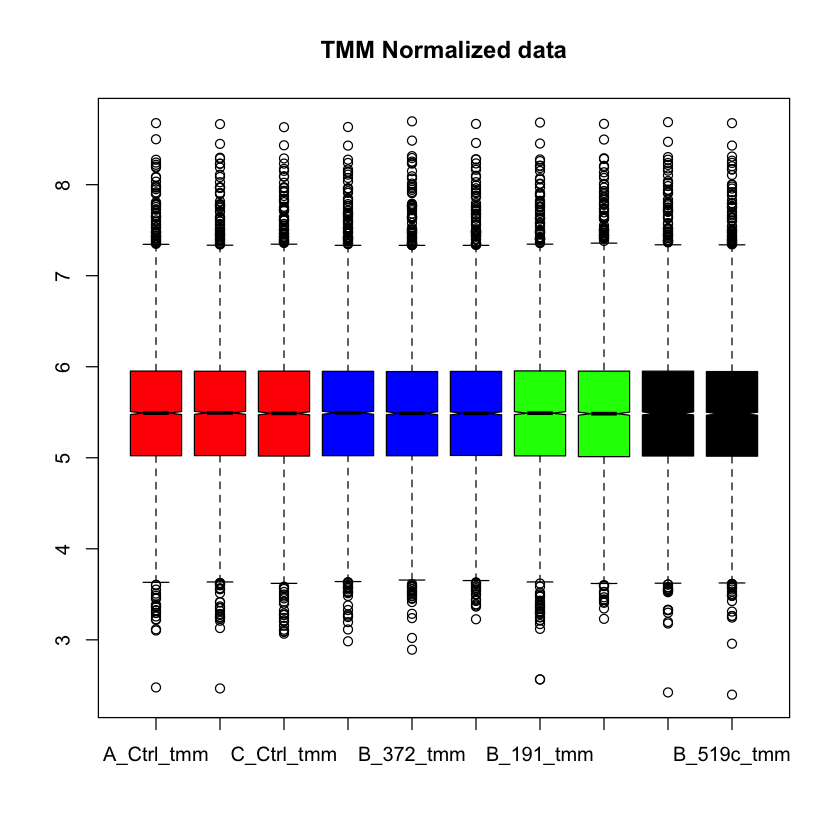

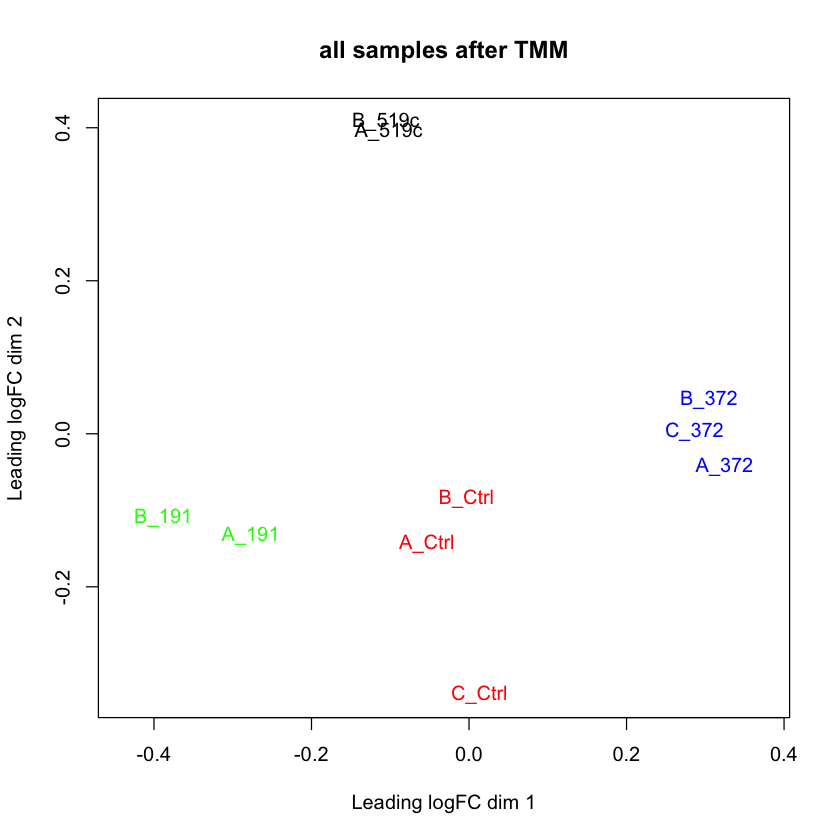

In [35]:
# get the biological sample data into a DGEList object
group = c(rep("C", length(C)), rep("x372", length(x372)), 
          rep("y191", length(y191)), rep("z519c", length(z519c)))
y <- DGEList(counts = data_tmt, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

tmt_tmm <- apply_tmm_factors(y, color = colors)

# check the clustering
plotMDS(y, col = colors, main = "all samples after TMM")

### TMM factors are very close to 1.0

We could have compositional differences between sample groups that the TMM factors would correct for. We have a couple of channels that need some modest library size adjustments. We do not have any TMM factors that are much different from 1.0, so there are no compositional differences of note. The box plots are very similar in size and well aligned. TMM usually gets the medians (box centers) aligned well. 

## Check coefficients of variation (CV) by condition

The CVs are a very useful metric in these large-scale experiments. Cell cultures often have lower CVs than tissue samples. Different TMT methods (MS2 versus SPS MS3) are also rather different.

[1] "Final median CVs by condition (%)"


C  x372  y191 z519c 
 6.08  6.89  4.15  3.84

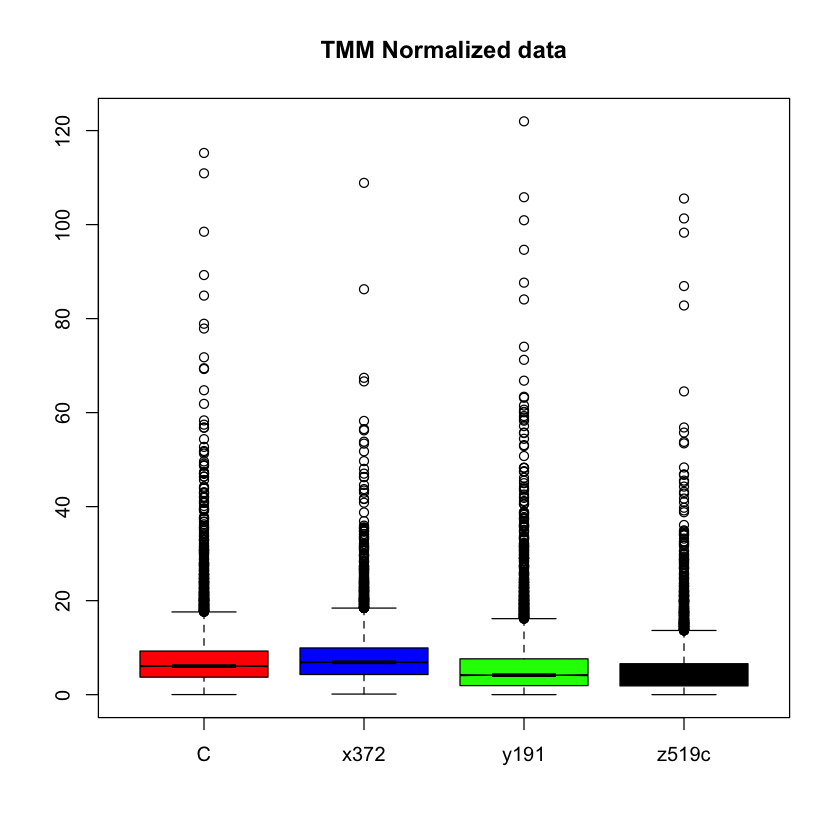

In [36]:
# put CVs in data frames to simplify plots and summaries
cv_tmm <- data.frame(C = CV(tmt_tmm[C]), x372 = CV(tmt_tmm[x372]), 
                     y191 = CV(tmt_tmm[y191]), z519c = CV(tmt_tmm[z519c]))

# see what the median CV values are
medians <- apply(cv_tmm, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

# also look at CV distributions
boxplot(cv_tmm, col = c("red", "blue", "green", "black"), notch = TRUE, 
        main = "TMM Normalized data")

# EdgeR statistical testing starts here

## Compute the shared variance trend

One of the most powerful features of edgeR (and limma) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 10 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR `estimateDisp` function that does all of this and a visualization function to check the result.

We loaded the IRS data into `DGEList` object `y` a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in `y`.

Design matrix not provided. Switch to the classic mode.


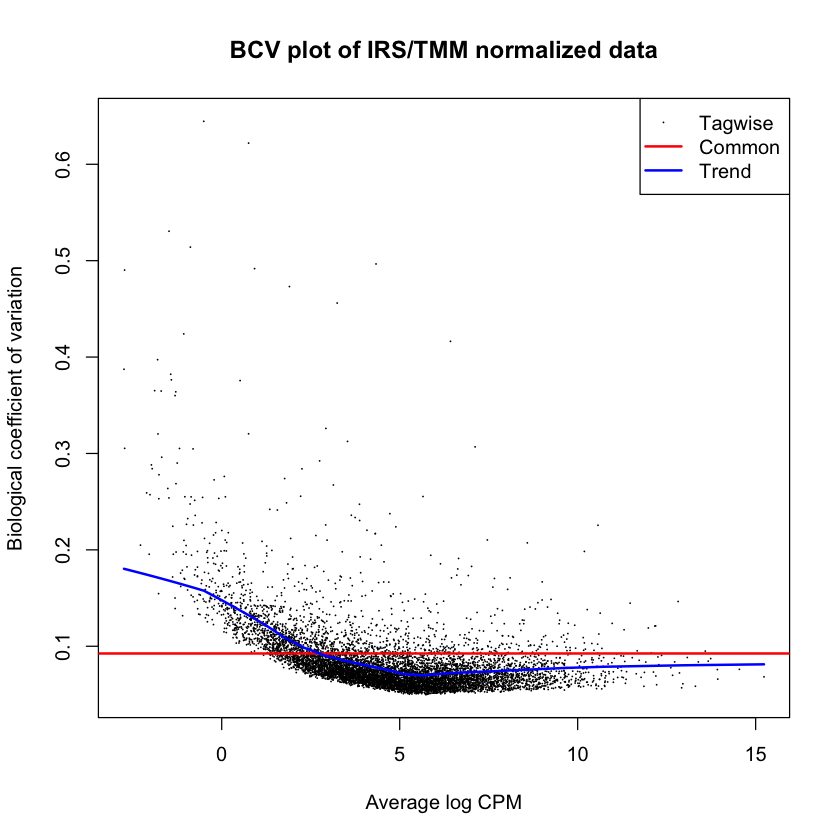

In [37]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

## <a name="C_372"></a>(1) Control versus 372 (3x3)

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `decideTestsDGE` call will tell us how many up and down regulated candidates we have at an FDR of 0.10. The `topTags` call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from `limma` to visualize the DE candidates, and then check the p-value distribution.

       x372-C
Down      557
NotSig   6963
Up        448

genes                 logFC      logCPM   PValue       FDR         
6233 sp|Q1RMZ1|SAMTR_HUMAN -1.4531549 2.957713 1.313780e-60 1.046820e-56
3176 sp|Q9UKG9|OCTC_HUMAN  -1.2705973 5.316743 1.661592e-58 6.619783e-55
3100 sp|Q9UHF7|TRPS1_HUMAN -1.0259234 5.371293 1.915257e-50 5.086923e-47
5160 sp|P37173|TGFR2_HUMAN -1.2678654 3.842266 4.088042e-44 8.143380e-41
6725 sp|P18827|SDC1_HUMAN  -1.2385218 2.449550 1.165832e-37 1.857870e-34
1315 sp|Q53EL6|PDCD4_HUMAN -0.8828737 6.962231 4.638980e-36 6.160565e-33
3750 sp|Q8NB46|ANR52_HUMAN -1.0024352 4.897248 3.580331e-31 4.075440e-28
3689 sp|O14682|ENC1_HUMAN   0.9893361 4.848200 3.110987e-27 3.098543e-24
6863 sp|P14316|IRF2_HUMAN  -0.9497031 2.263869 3.383493e-26 2.995519e-23
3268 sp|O15240|VGF_HUMAN    1.0543952 5.164532 1.337092e-23 1.065395e-20

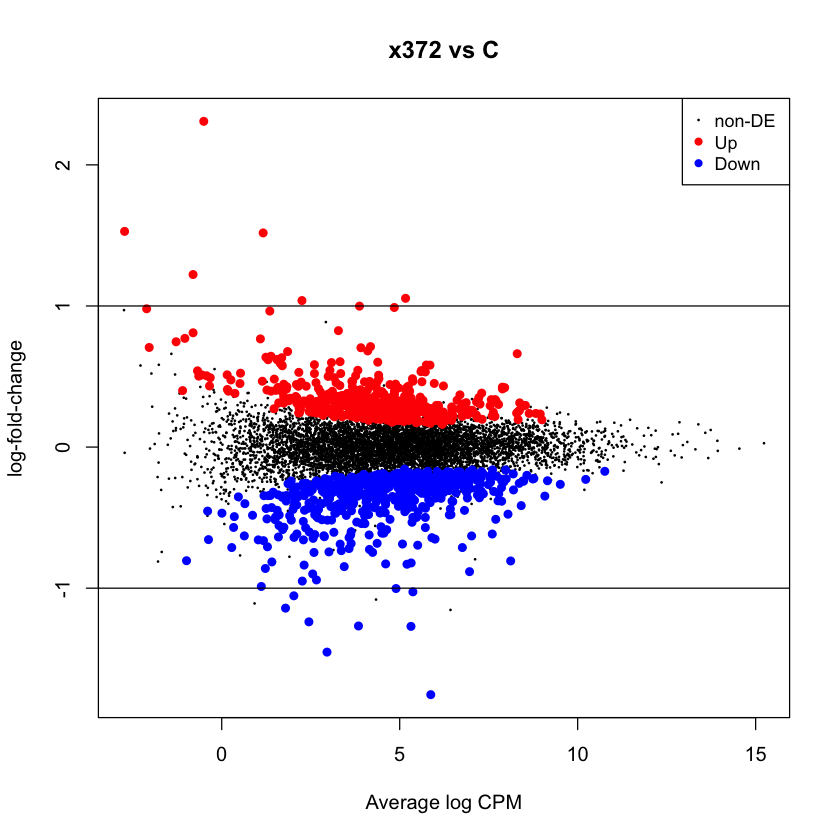

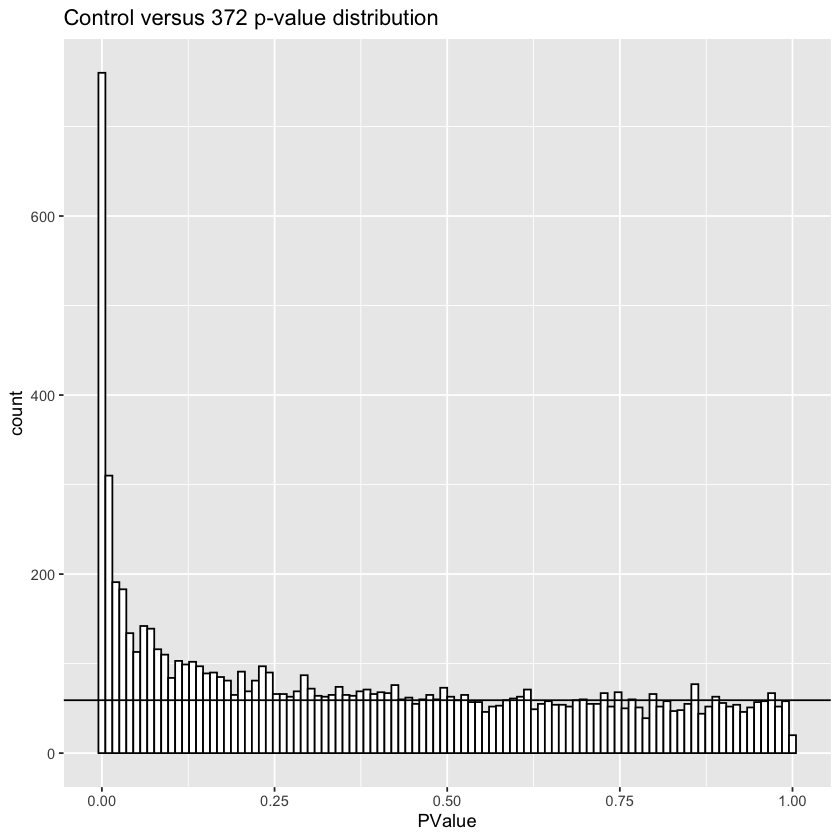

In [38]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("C", "x372"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("Control versus 372 p-value distribution")

### We have over 1,000 DE candidates with small fold-changes

We have 1,005 candidates; however, the fold-changes are mostly much less than 2-fold. The top tags have quite small p-values which must be due to small variances. The p-value distribution looks typical when we have true DE candidates - a low p-value spike and a flat background distribution. 


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

We will make MA plots, scatter plots, and a volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [39]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, C, "C", x372, "x372")

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_C_372")

# accumulate the testing results
all_results <- results_temp

### Count candidates and look at fold-change distributions

candidate n   
1 high       410
2 med        336
3 low        259
4 no        6963

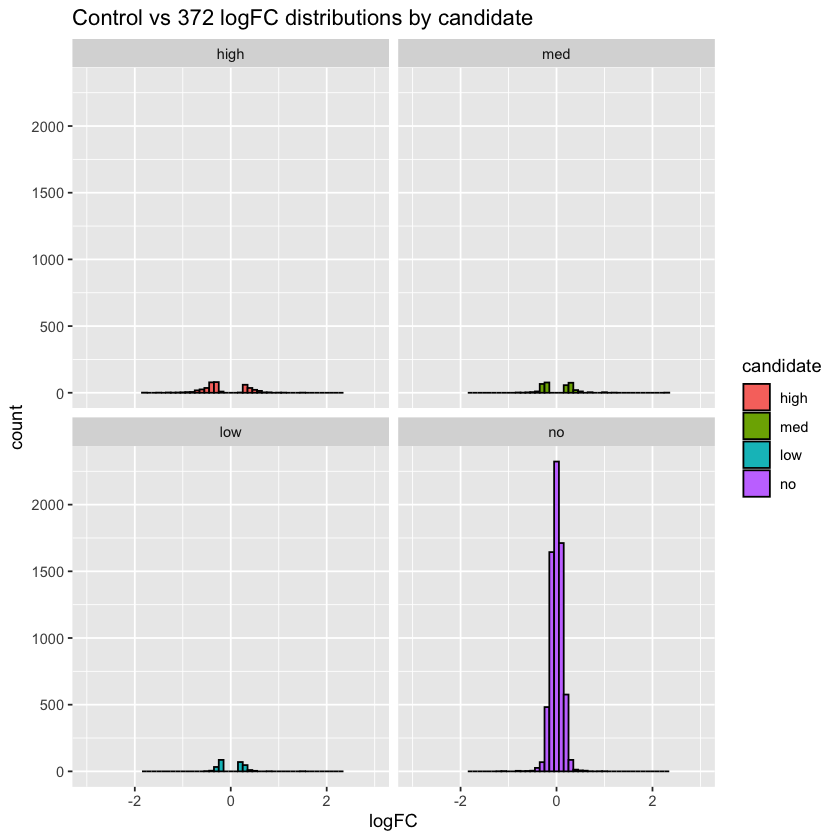

In [40]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("Control vs 372 logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

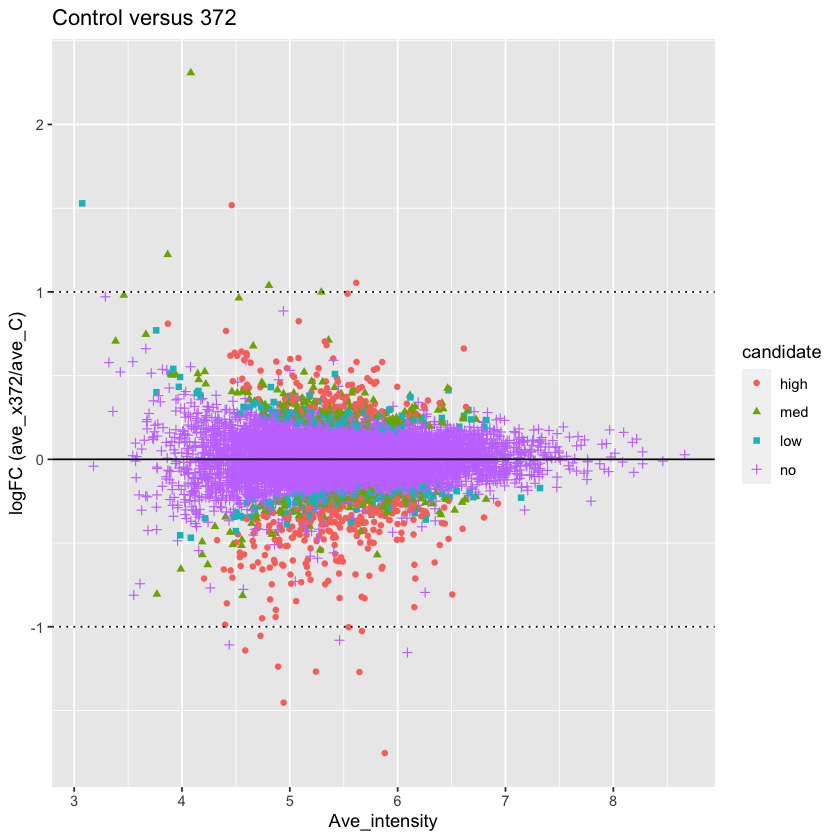

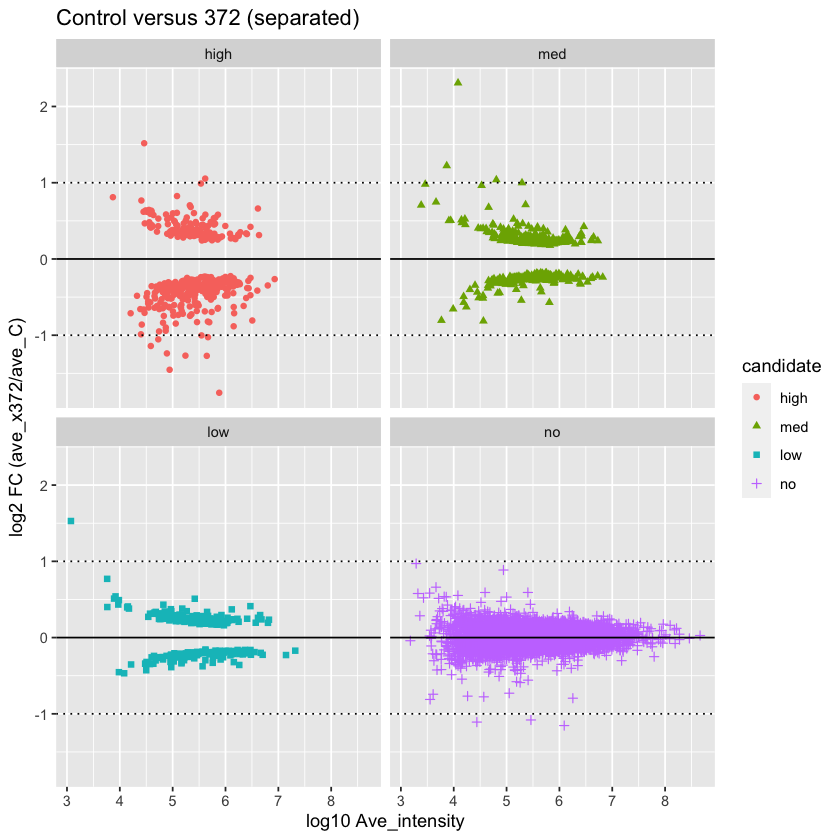

In [41]:
# make MA plots
MA_plots(results, "ave_C", "ave_x372", "Control versus 372")

### Scatter plots

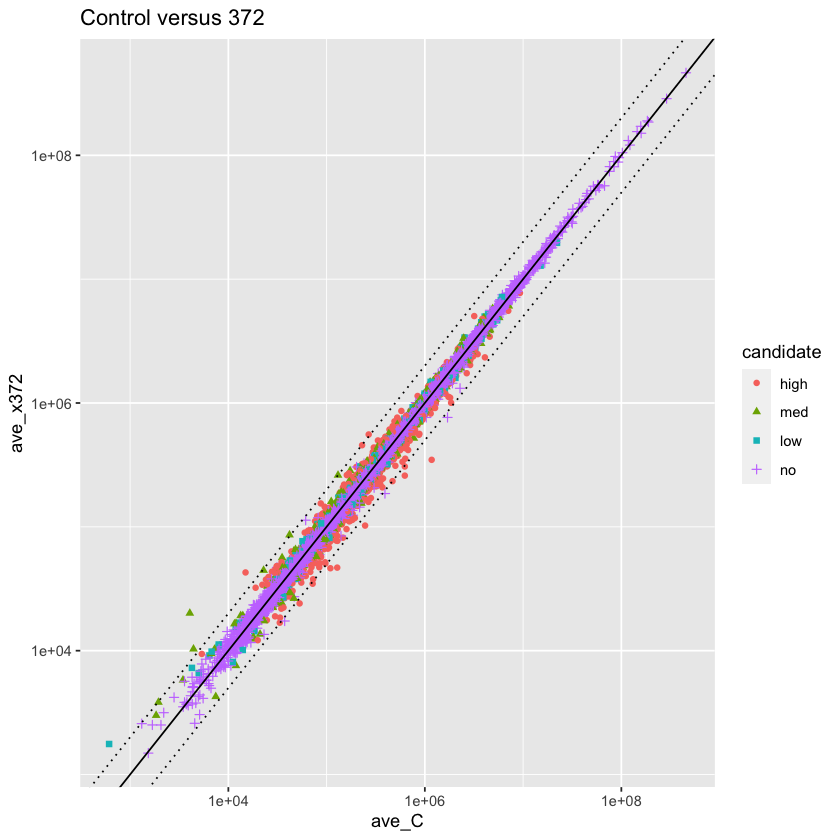

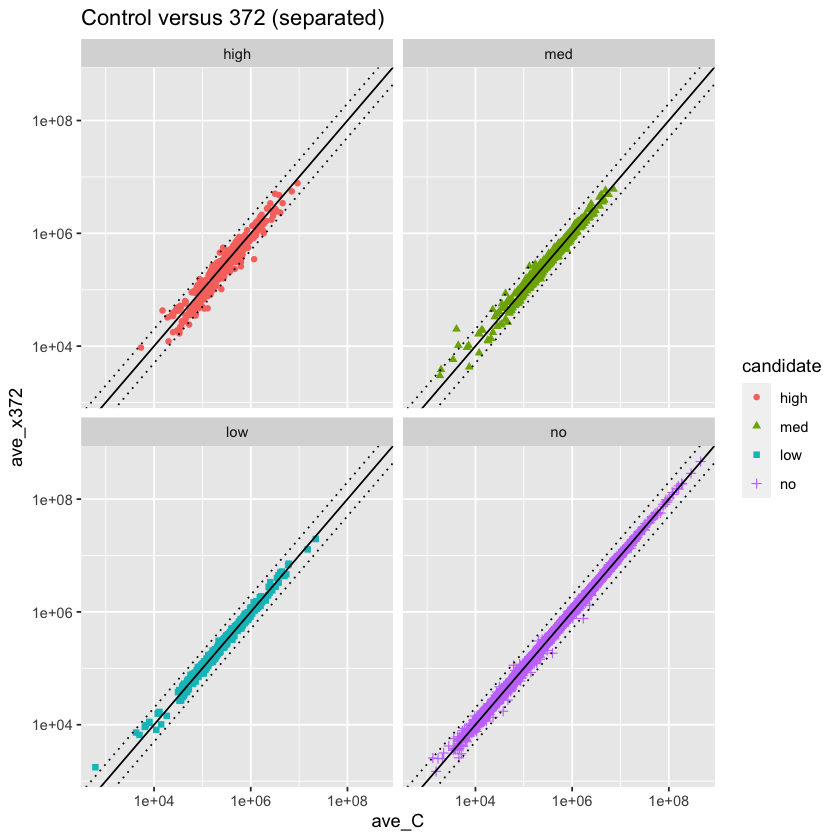

In [42]:
# make scatter plots
scatter_plots(results, "ave_C", "ave_x372", "Control versus 372")

### Volcano plot

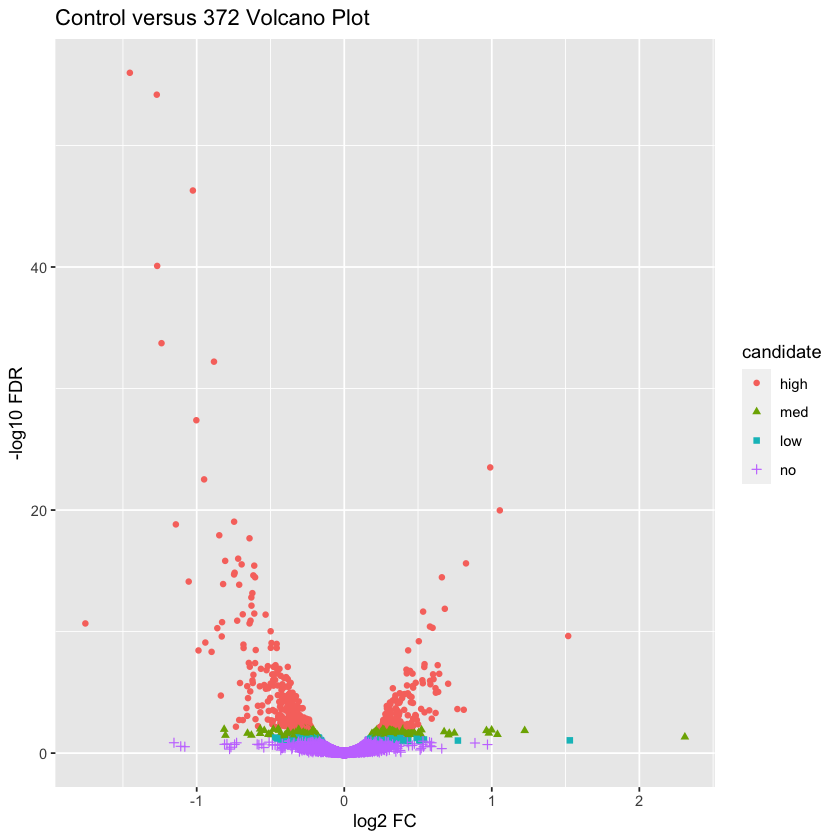

In [43]:
# make a volcano plot
volcano_plot(results, "ave_C", "ave_x372", "Control versus 372")

### DE candidates have different expression from the main background

Although the DE candidates have rather small expression differences, they do seem to have over and under expression that differs from the unchanged background. We do seem to have a good balance between up and down regulation.

### Check some individual protein expression (top 10 in each direction)

We will rank the DE candidates by p-values (FDR) and look at the top 10 in each expression direction.

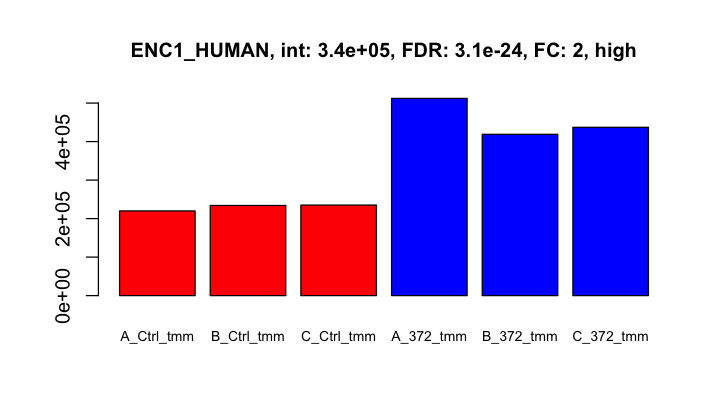

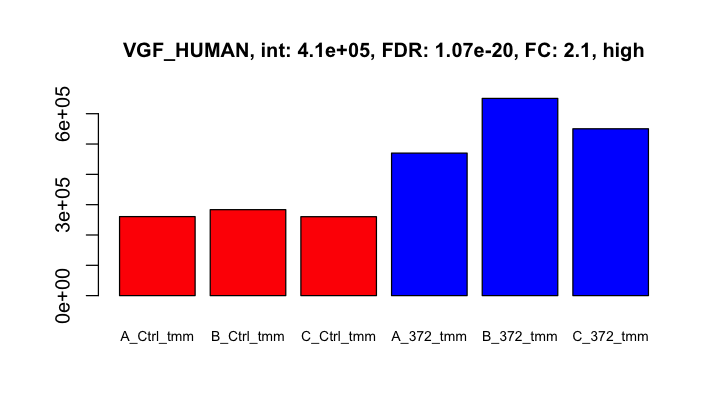

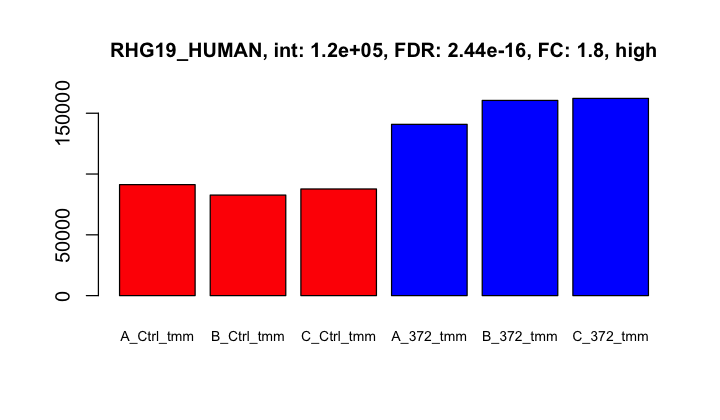

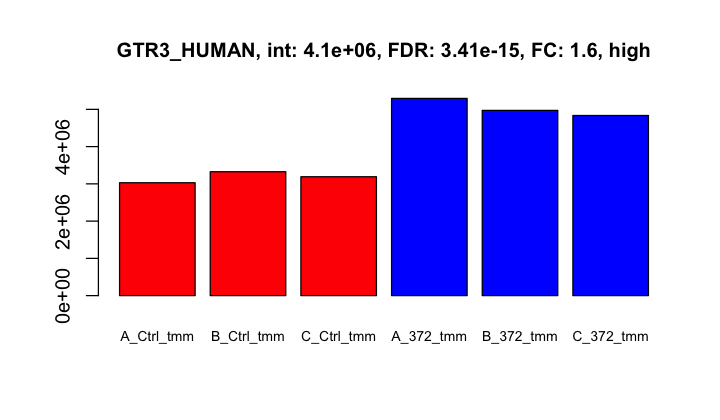

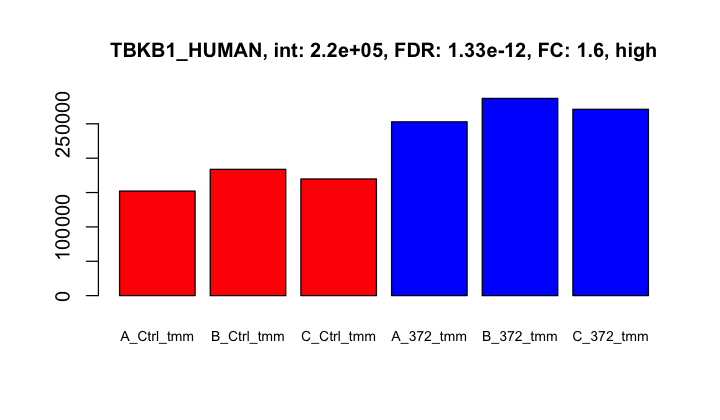

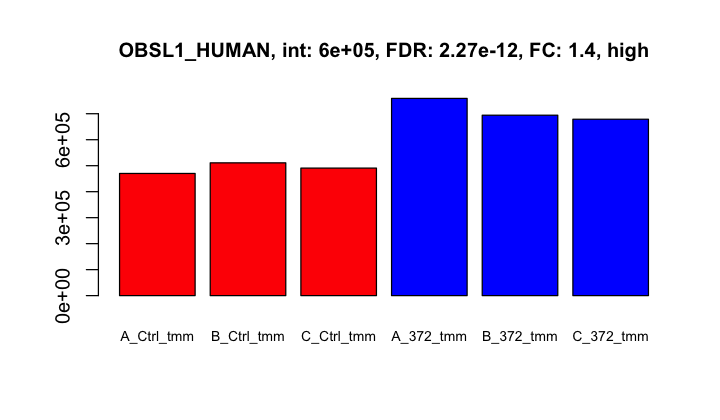

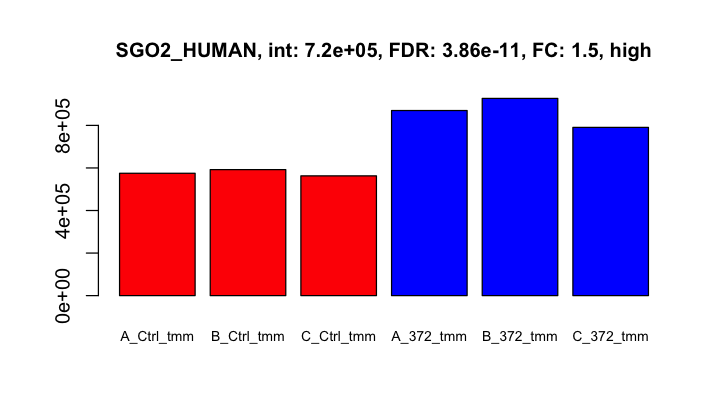

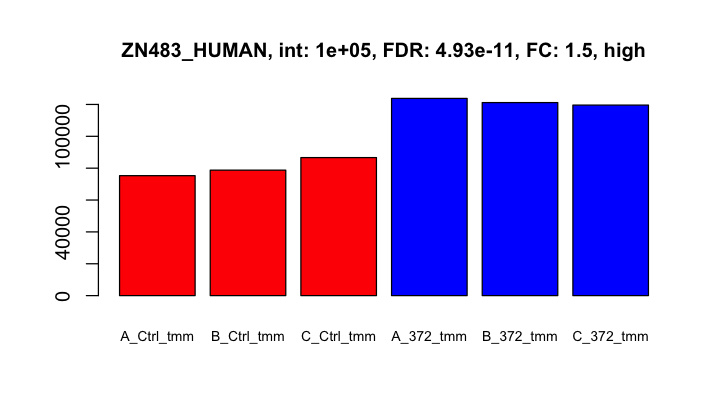

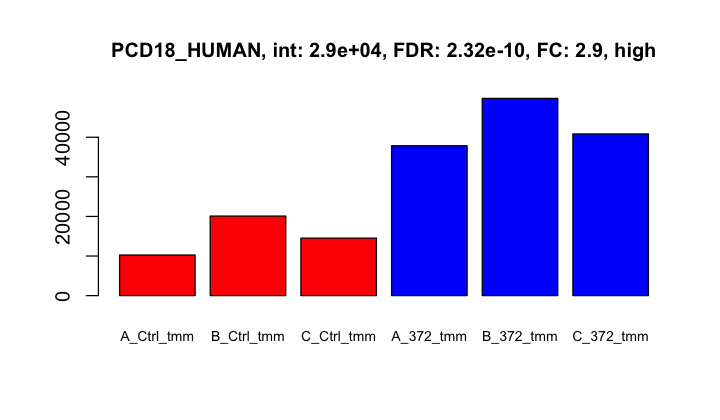

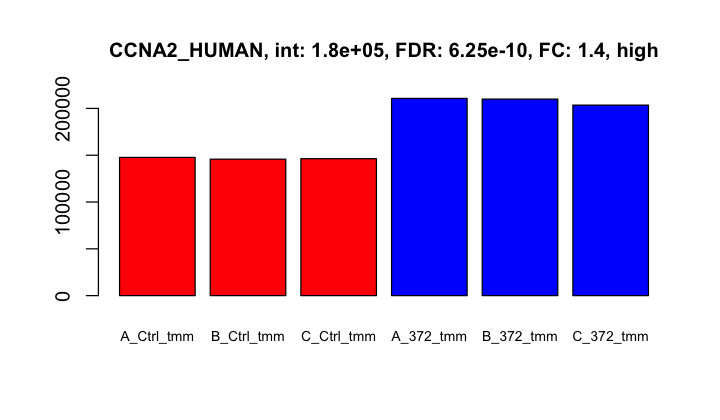

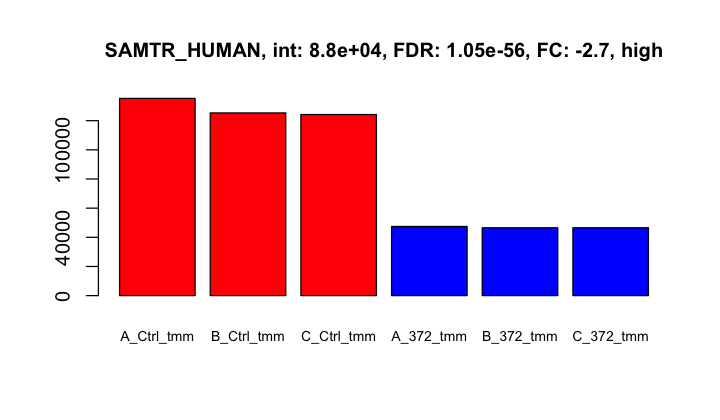

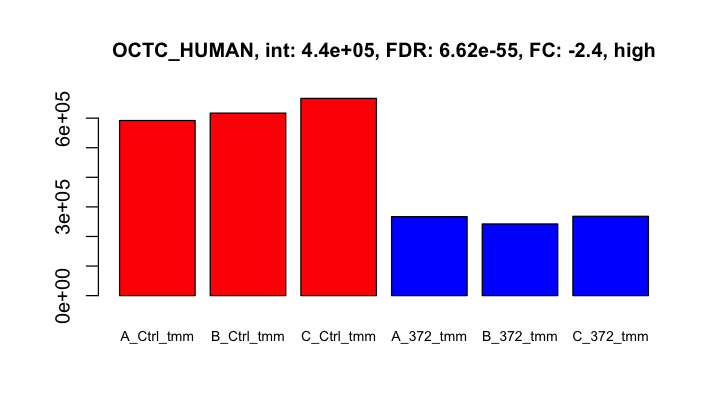

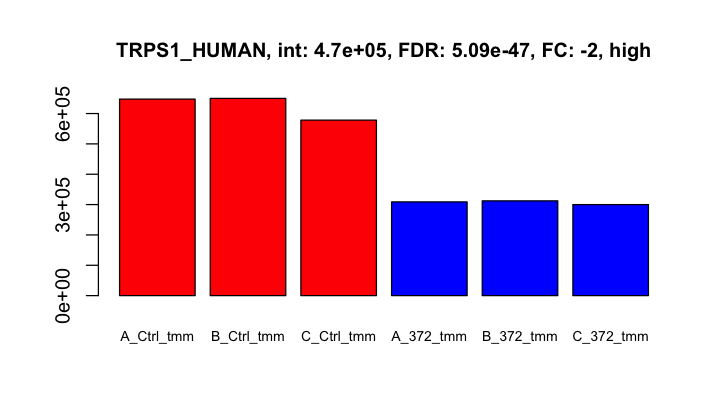

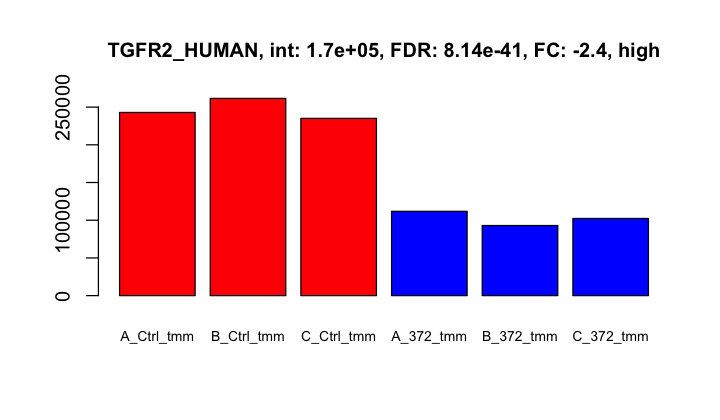

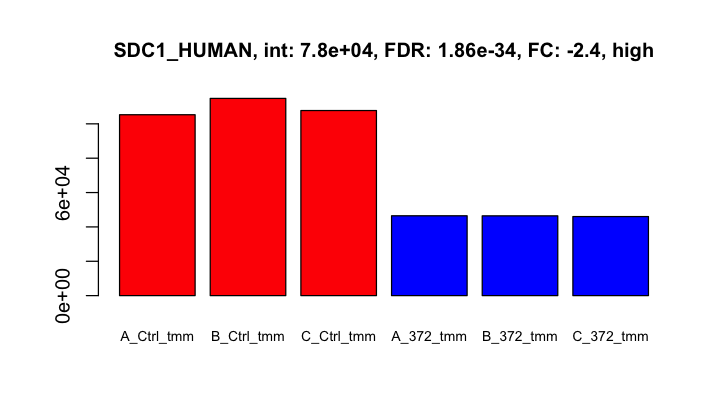

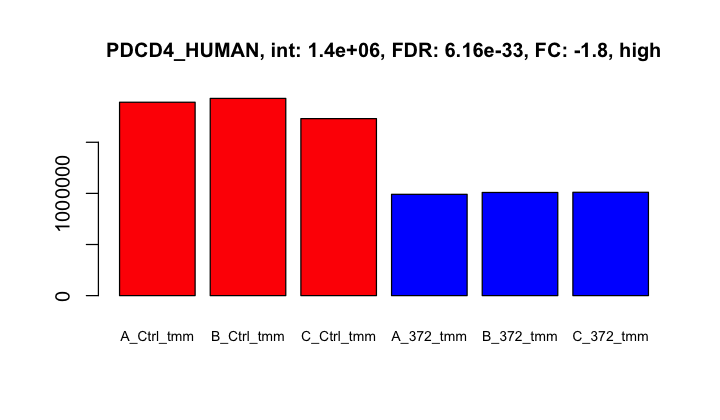

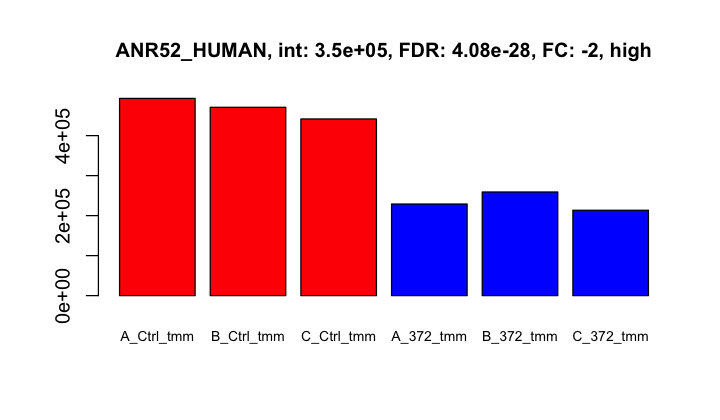

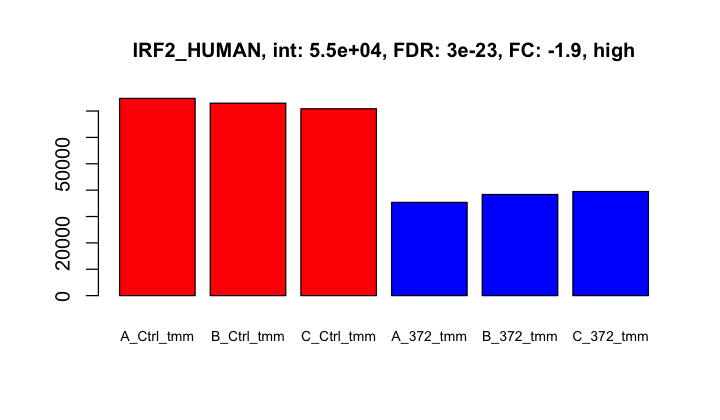

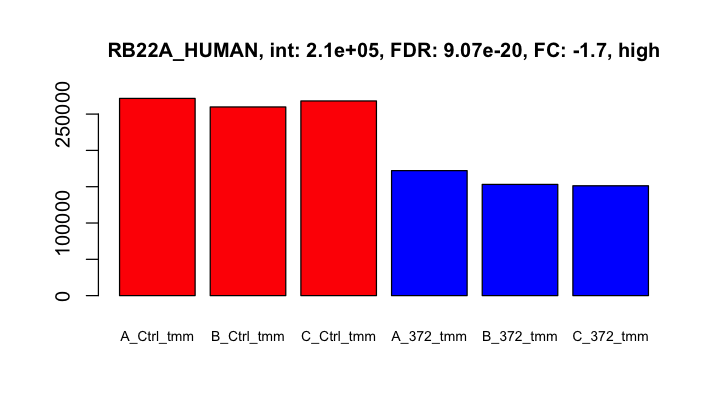

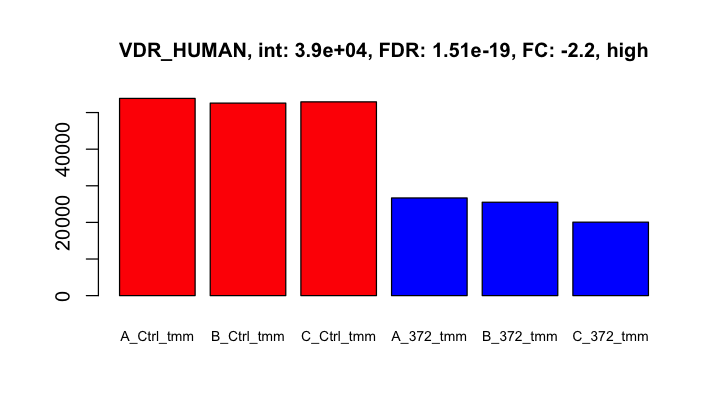

In [44]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 3, 10)
set_plot_dimensions(7, 7)

## <a name="C_191"></a> (2) Control versus 191 (3x2)

Compare the non-targeting control treatment to the miR-191-5p mimic.

       y191-C
Down      188
NotSig   7658
Up        122

genes                 logFC    logCPM   PValue        FDR          
2631 sp|P09914|IFIT1_HUMAN 2.295022 5.720015 4.692349e-104 3.738864e-100
4597 sp|Q15646|OASL_HUMAN  2.290286 4.272836  1.234862e-96  4.919692e-93
4033 sp|Q8TCB0|IFI44_HUMAN 1.940631 4.680568  2.108913e-84  5.601273e-81
5184 sp|Q00978|IRF9_HUMAN  1.741562 3.791915  1.527917e-67  3.043610e-64
2584 sp|P09913|IFIT2_HUMAN 1.928620 5.749392  3.350785e-65  5.339810e-62
2665 sp|Q16666|IF16_HUMAN  1.475681 5.684269  2.806494e-62  3.727024e-59
1963 sp|O95786|DDX58_HUMAN 1.252491 6.251067  8.013729e-62  9.121914e-59
3937 sp|Q9BYX4|IFIH1_HUMAN 1.535411 4.754303  2.760894e-58  2.749851e-55
3098 sp|Q13325|IFIT5_HUMAN 1.188753 5.350405  2.672516e-47  2.366067e-44
1058 sp|O14879|IFIT3_HUMAN 1.737843 7.303329  3.155345e-43  2.514179e-40

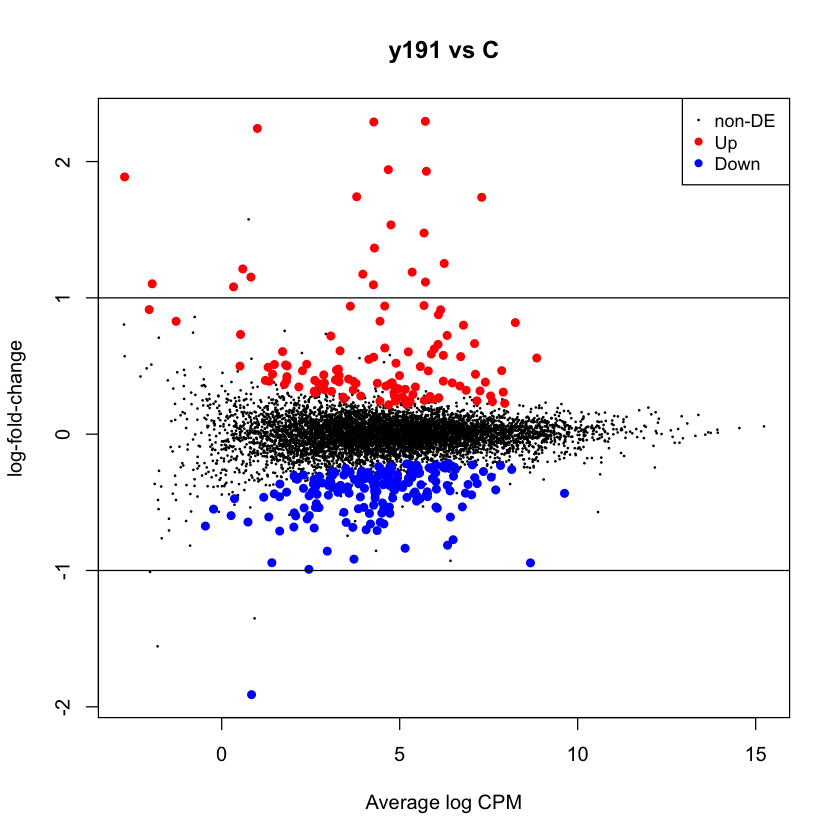

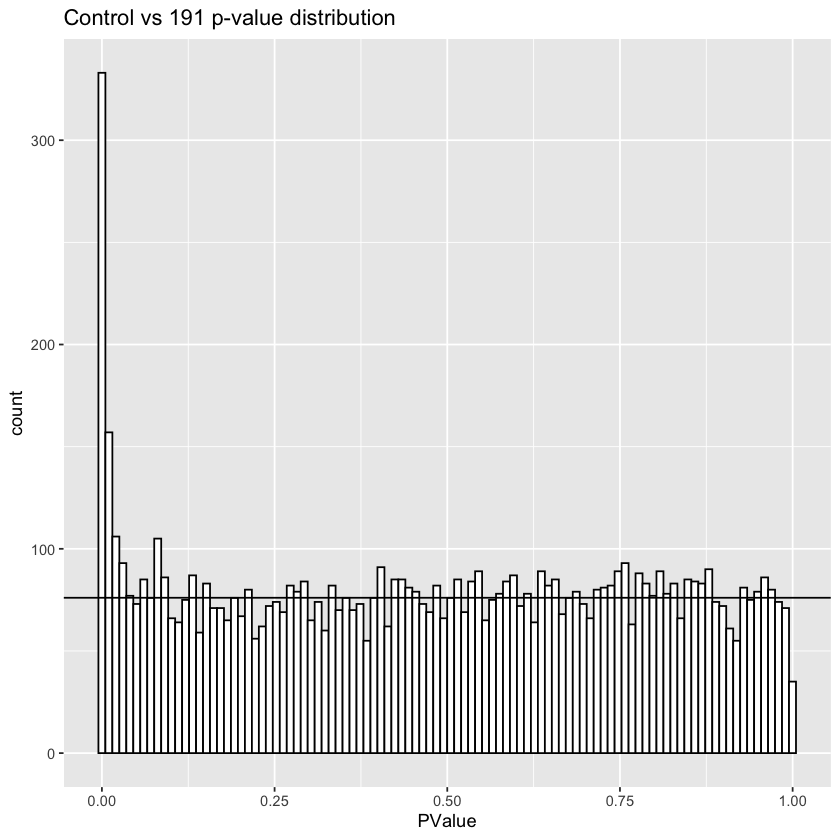

In [45]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("C", "y191"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black") # 2-fold change lines

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("Control vs 191 p-value distribution")

### We have fewer candidates

We have 310 candidates. The other plots look pretty good.

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

In [46]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, C, "C", y191, "y191")

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_C_191")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high       148
2 med         82
3 low         80
4 no        7658

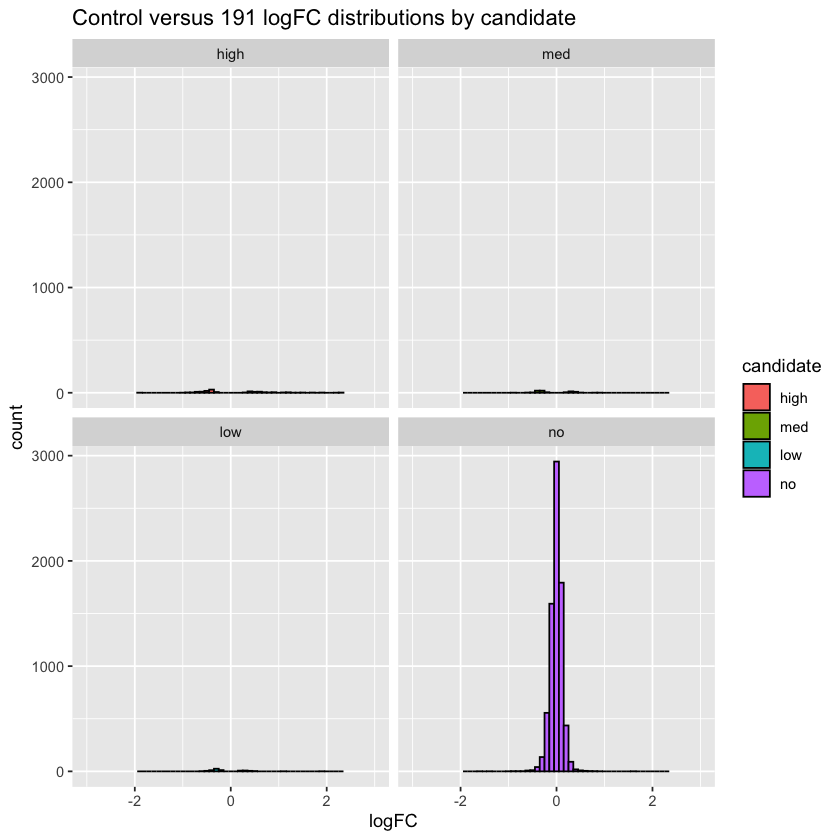

In [47]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("Control versus 191 logFC distributions by candidate")

### MA plots

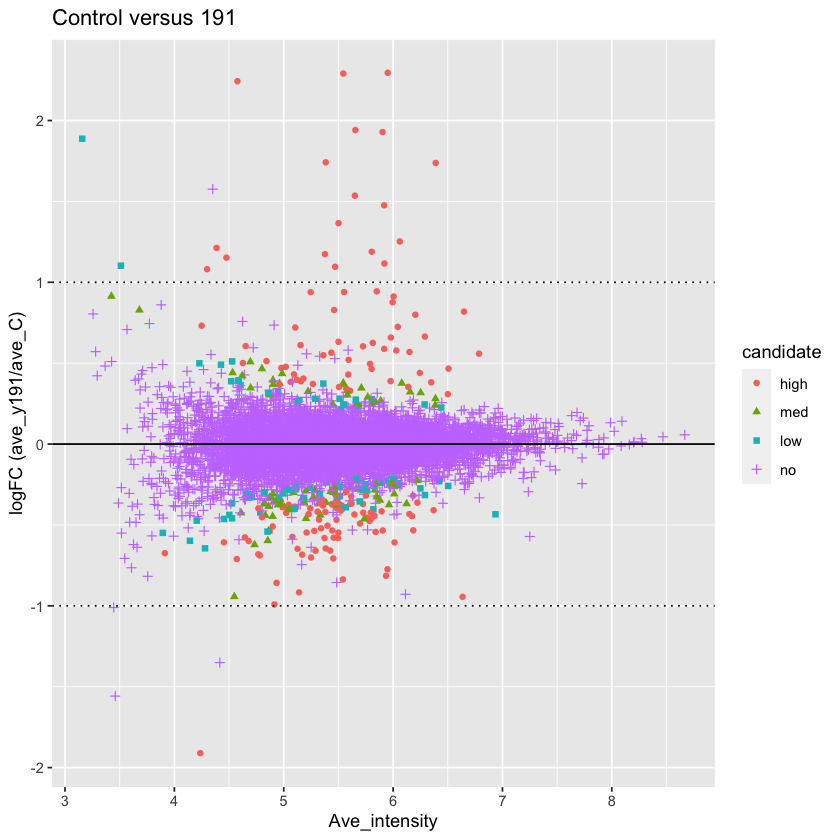

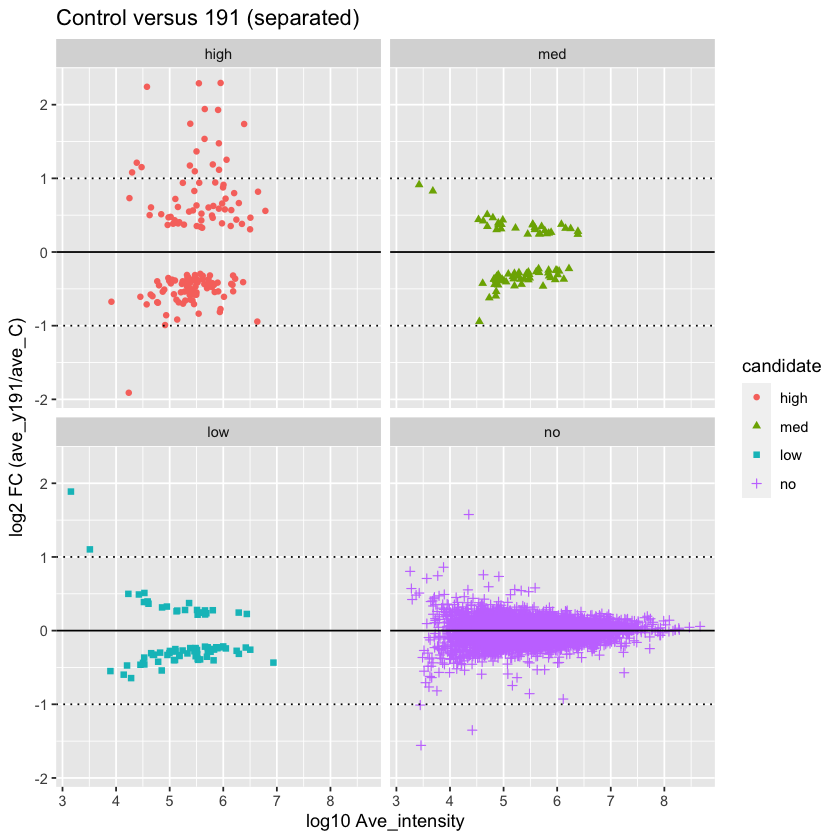

In [48]:
# make MA plots
MA_plots(results, "ave_C", "ave_y191", "Control versus 191")

### Scatter plots

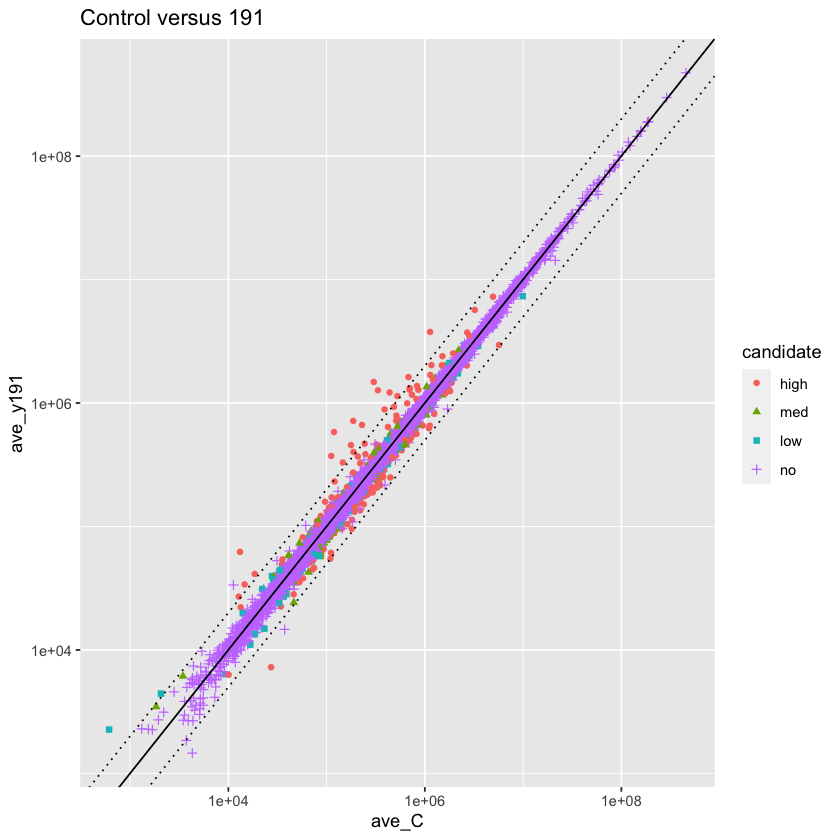

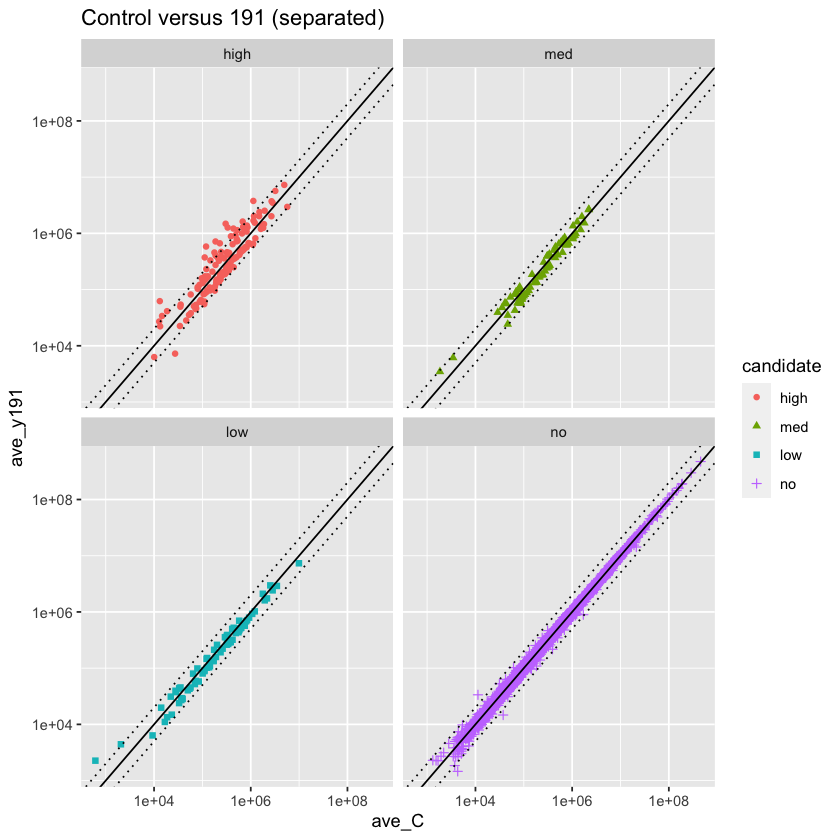

In [49]:
# make scatter plots
scatter_plots(results,  "ave_C", "ave_y191", "Control versus 191")

### Volcano plot

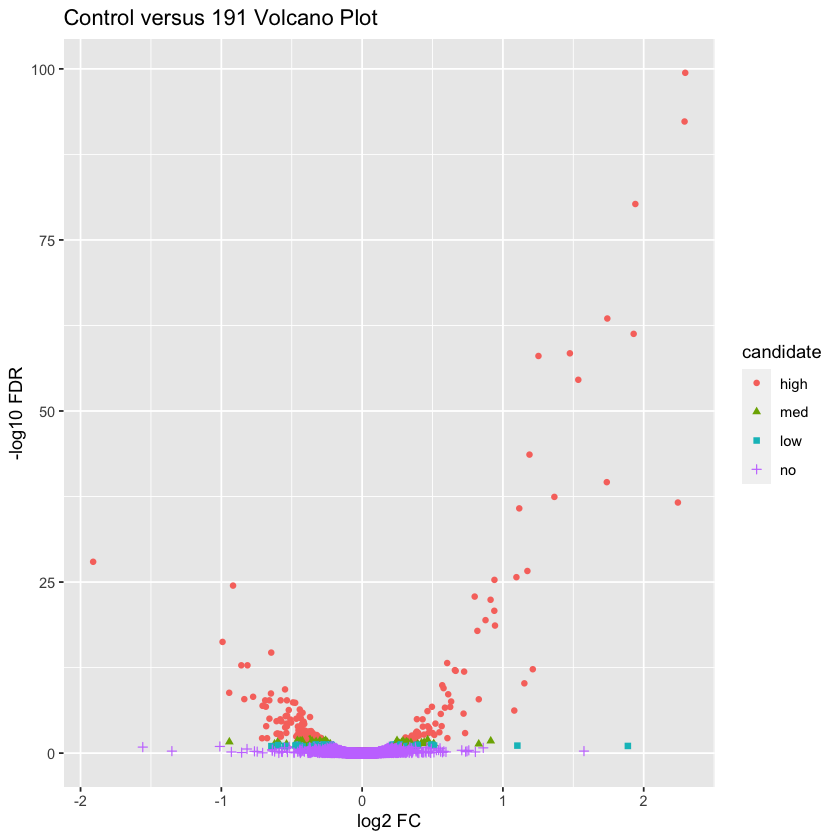

In [50]:
# make a volcano plot
volcano_plot(results,  "ave_C", "ave_y191", "Control versus 191")

### Expression patterns seem okay

We have fewer DE candidates, but the plots are all pretty similar to what we saw in the first comparison. We do have some larger fold-changes for over-expressed proteins.

### Check some individual protein expression

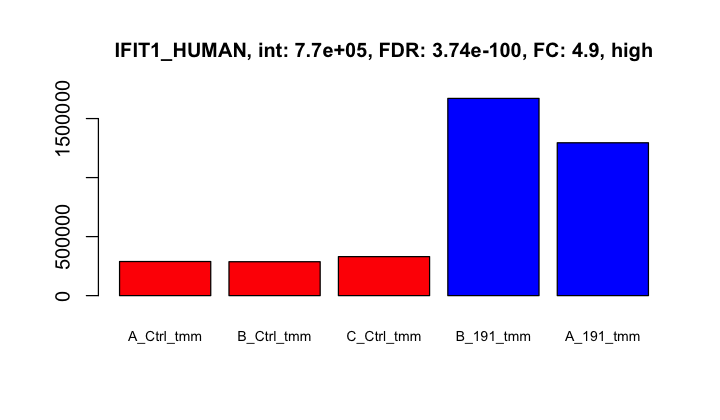

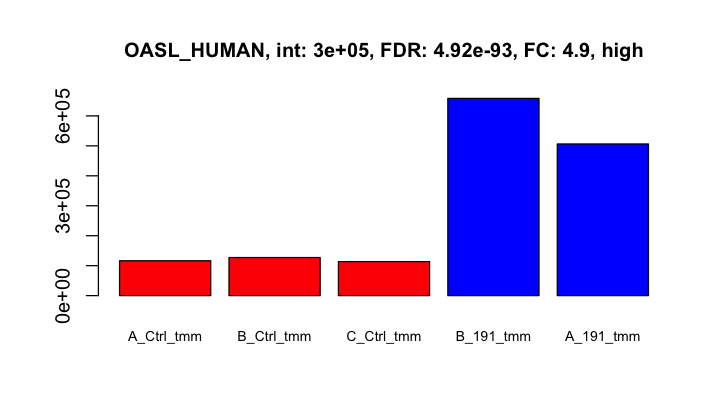

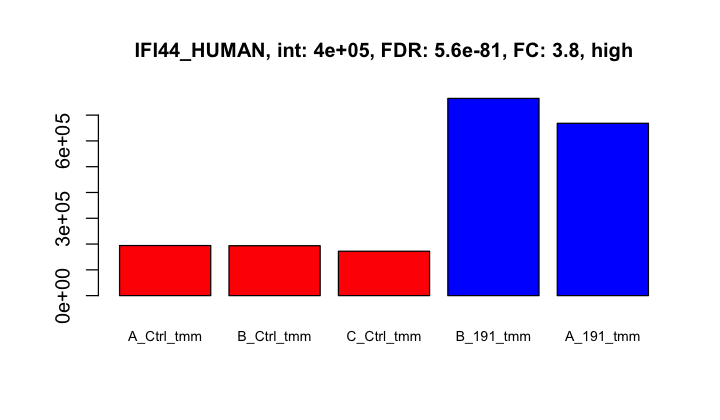

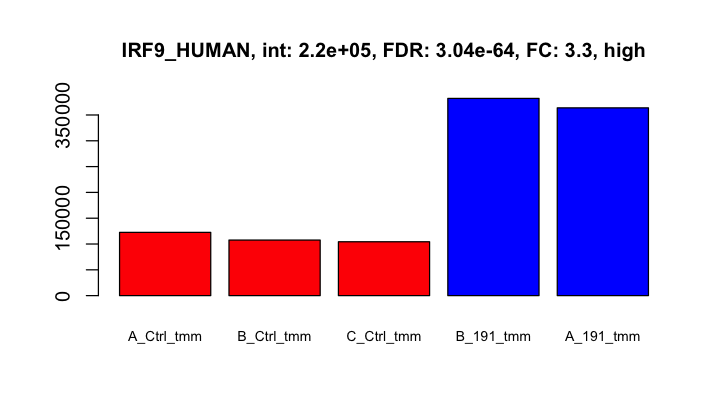

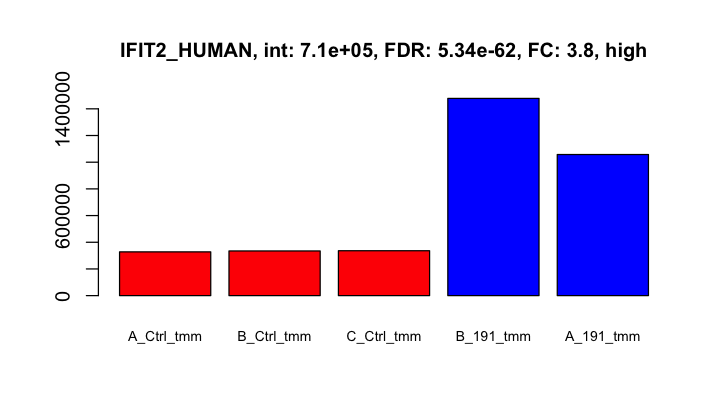

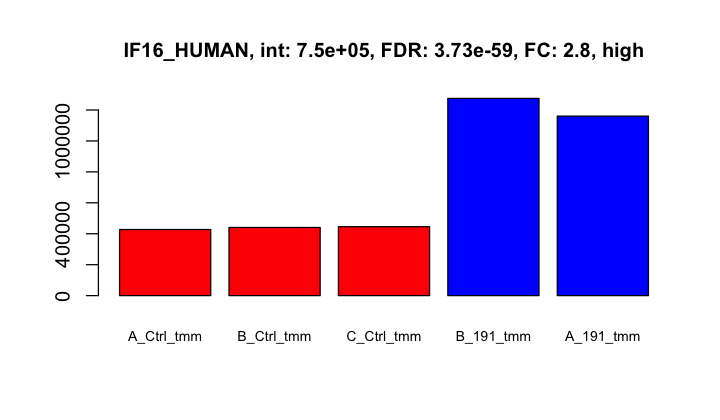

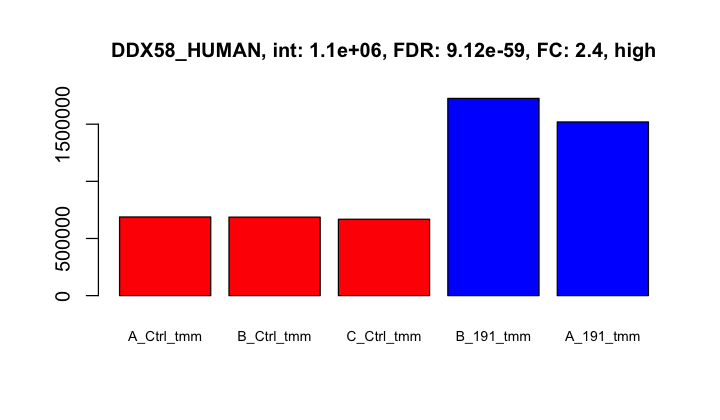

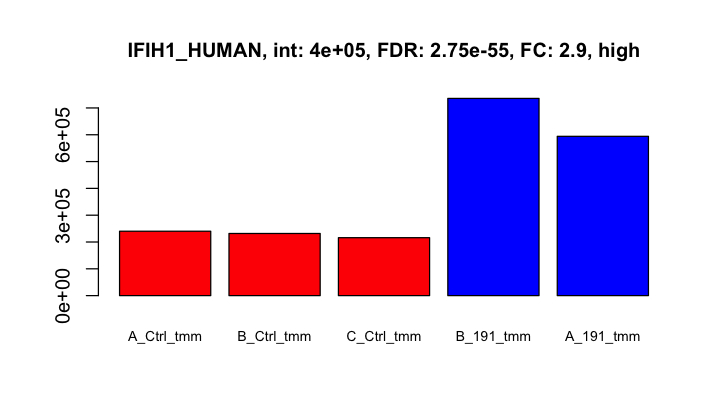

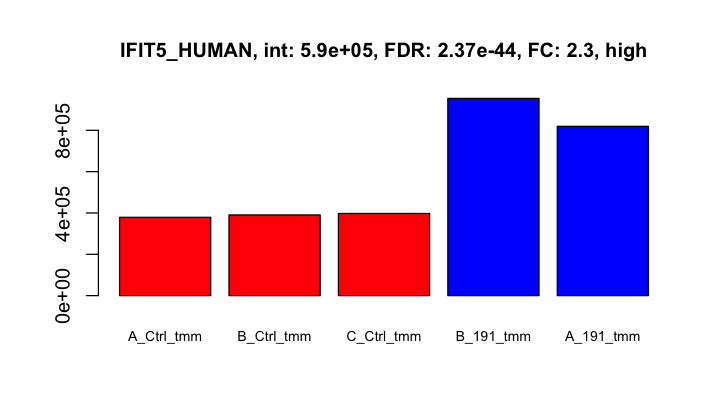

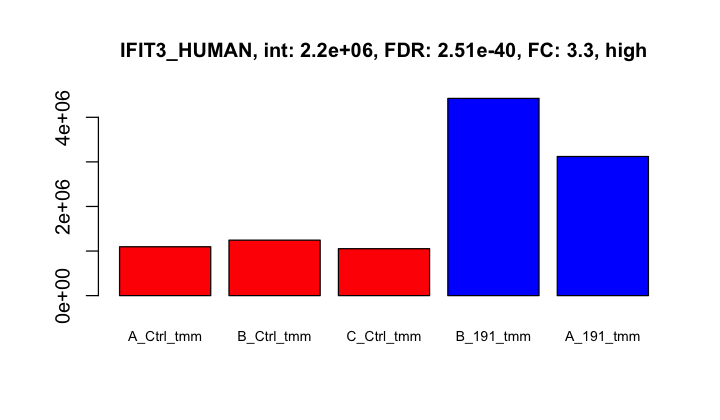

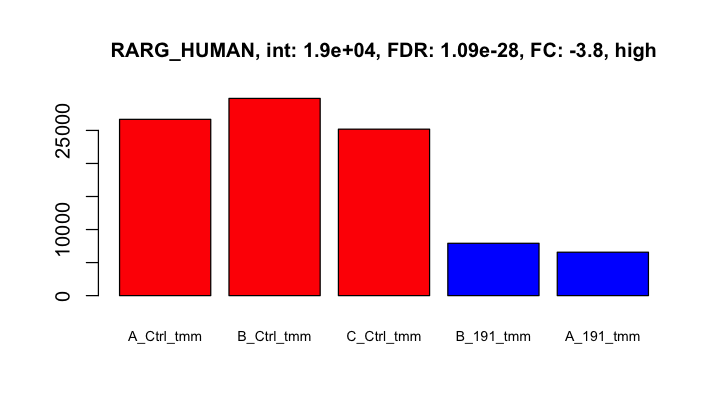

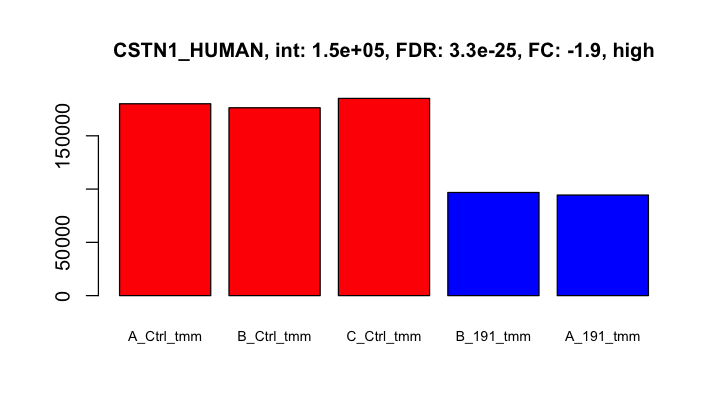

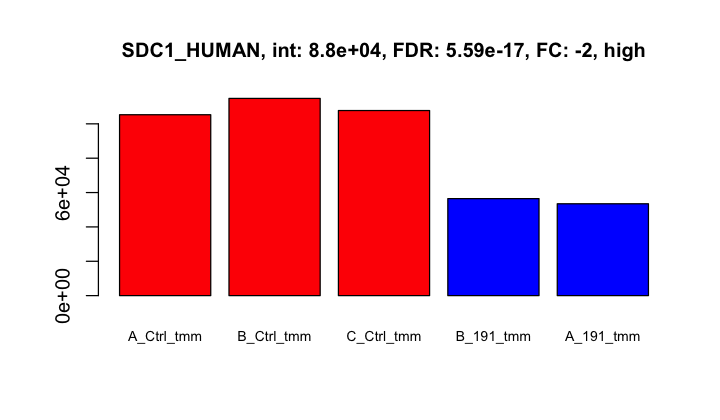

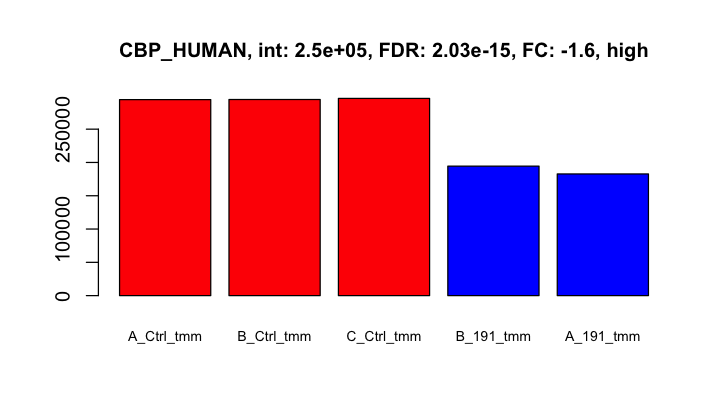

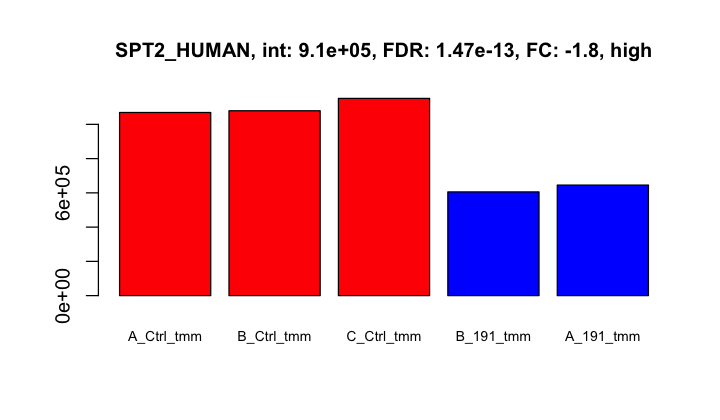

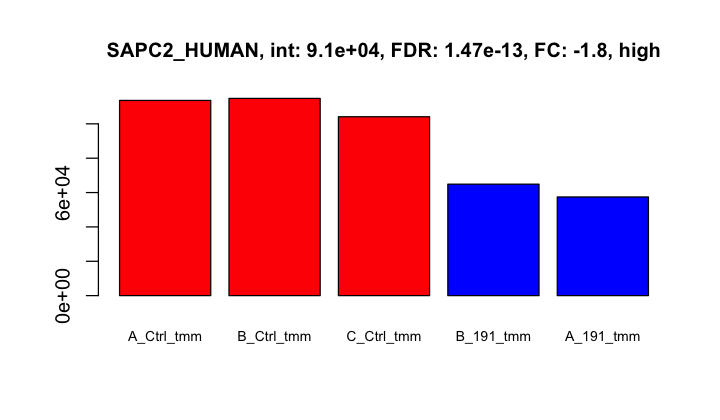

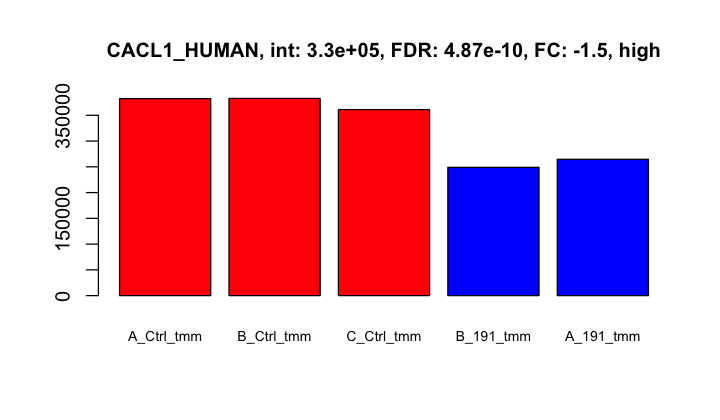

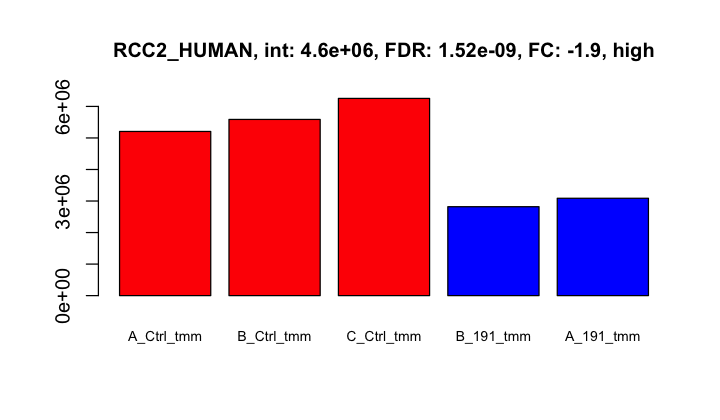

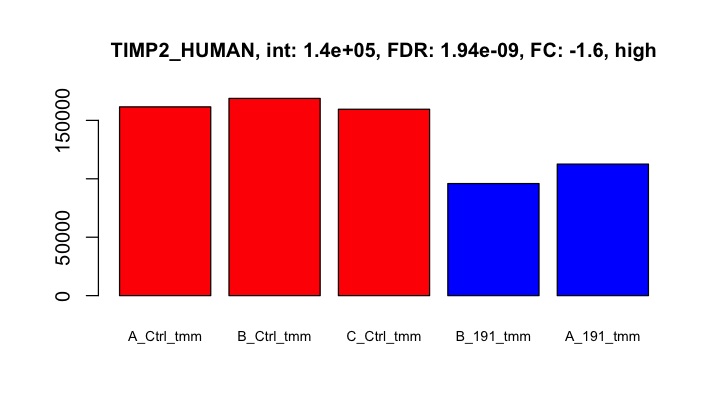

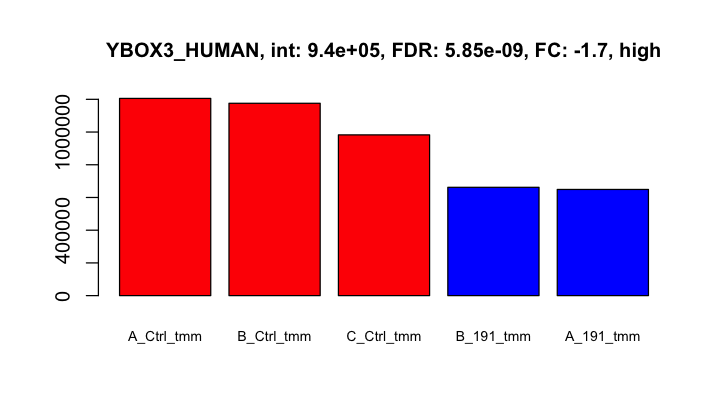

In [51]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 2, 10)
set_plot_dimensions(7, 7)

### We are using trended variance to help with low replicate numbers

This is a 3 versus 2 comparison, but we are using the trended variance computed from all 10 channels. This should stabalize the p-values and be more conservative.

----

## <a name="C_519"></a> (3) Control versus 519c (3x2)

Compare the non-targeting controls to the miR-519c-3p mimics. This is another 3 by 2 comparison.

       z519c-C
Down       754
NotSig    6634
Up         580

genes                 logFC      logCPM   PValue       FDR         
4684 sp|Q96GX5|GWL_HUMAN   -1.0919405 4.143485 2.418777e-40 1.927281e-36
6725 sp|P18827|SDC1_HUMAN  -1.3759079 2.449550 6.146504e-35 2.448767e-31
1727 sp|O00469|PLOD2_HUMAN -0.8616713 6.470758 7.854106e-34 2.086051e-30
6233 sp|Q1RMZ1|SAMTR_HUMAN -1.2123207 2.957713 3.312274e-33 6.598049e-30
2254 sp|P29279|CCN2_HUMAN   1.2051536 5.970726 8.344942e-32 1.329850e-28
5329 sp|P62745|RHOB_HUMAN   1.3038492 3.647830 1.870969e-31 2.484647e-28
5160 sp|P37173|TGFR2_HUMAN -1.1999167 3.842266 1.245810e-30 1.418088e-27
3268 sp|O15240|VGF_HUMAN    1.3126188 5.164532 3.036253e-30 3.024108e-27
1767 sp|Q00534|CDK6_HUMAN   0.8931909 6.415258 5.588379e-30 4.947578e-27
2486 sp|O00622|CCN1_HUMAN   0.8995233 5.803570 8.154487e-30 6.497495e-27

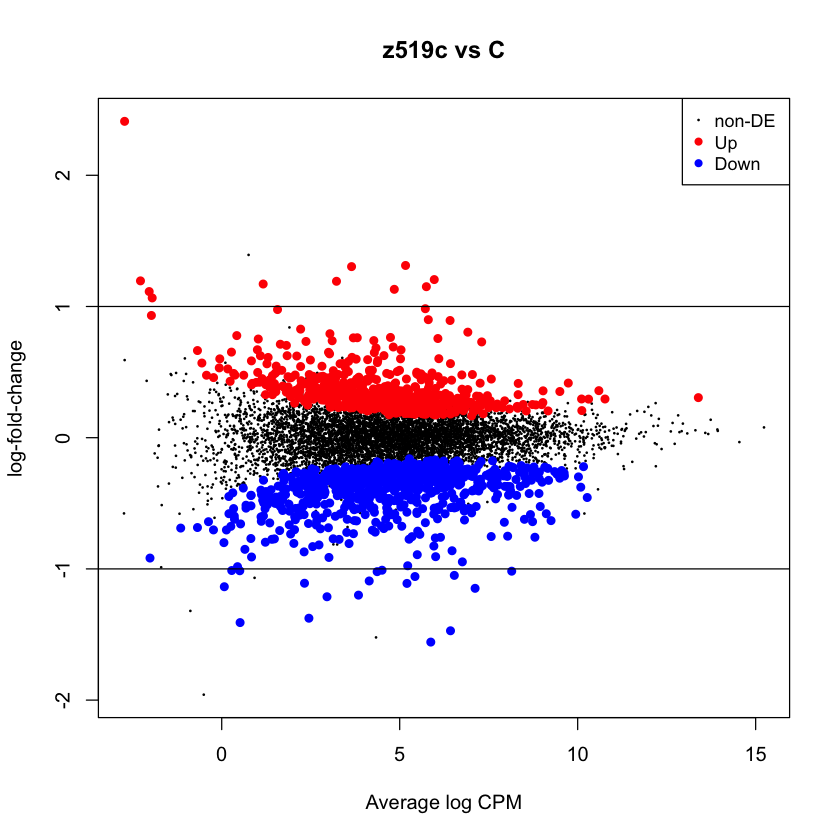

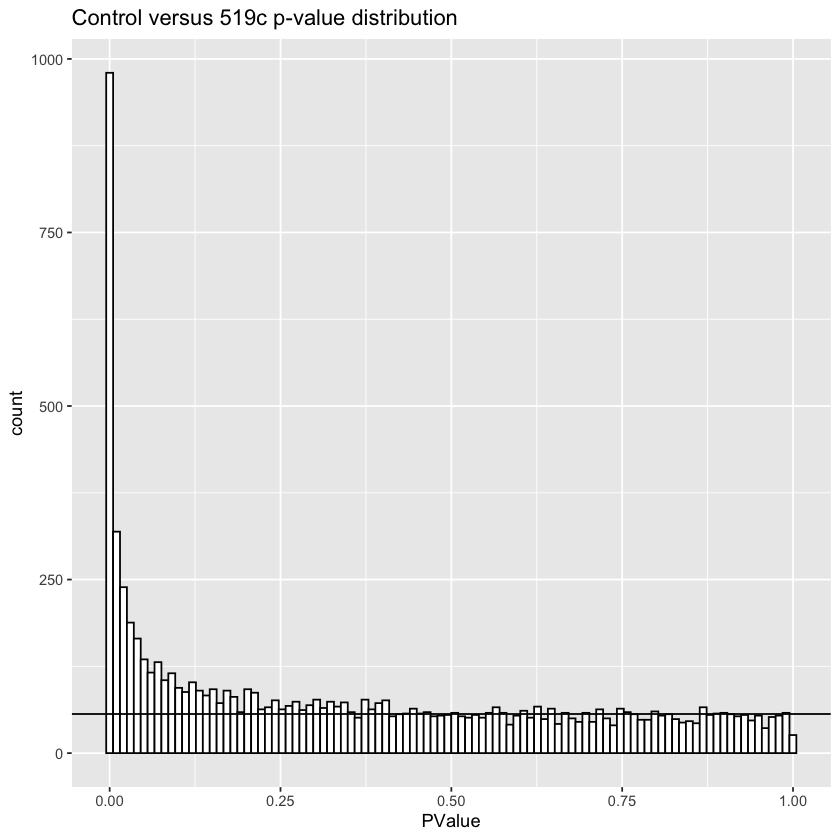

In [52]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("C", "z519c"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("Control versus 519c p-value distribution")

### We have over 1,300 DE candidates

We have more DE candidates for this comparison (1,334). The MDS cluster plots and CVs indicated that the two 519c samples were very similar. We are still using the trended variance from all 10 channels. We might have an even larger number of positive testing results if we allowed the lower 519c variance to drive candidates. The increased number of candidates suggests that we might have some larger fold-changes here.  

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

In [53]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, C, "C", z519c, "z519c")

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_C_519")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high       638
2 med        396
3 low        300
4 no        6634

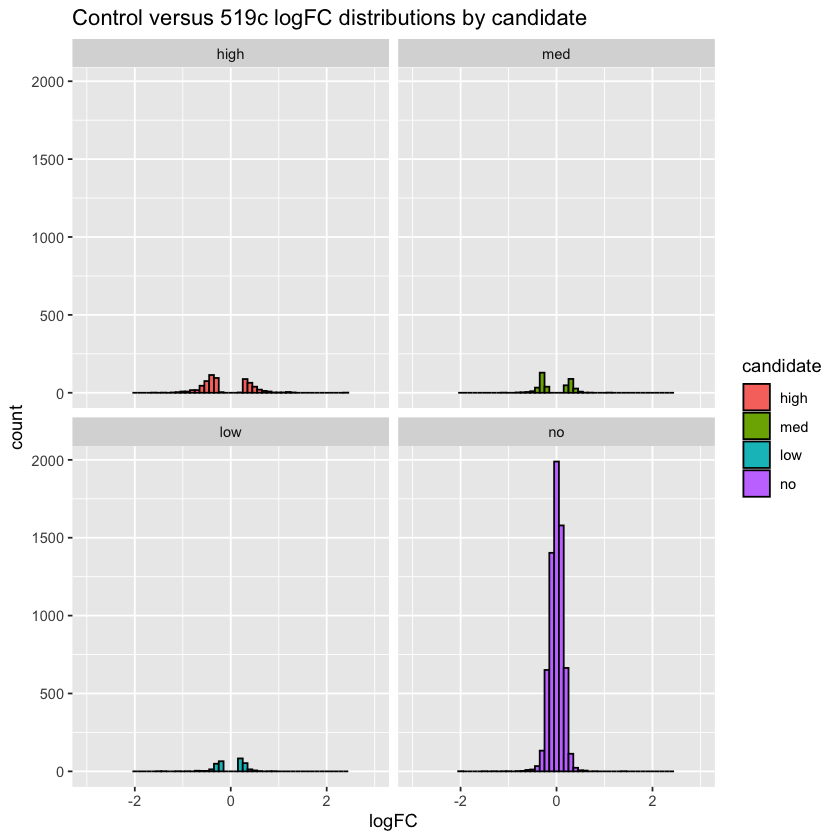

In [54]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("Control versus 519c logFC distributions by candidate")

### MA plots

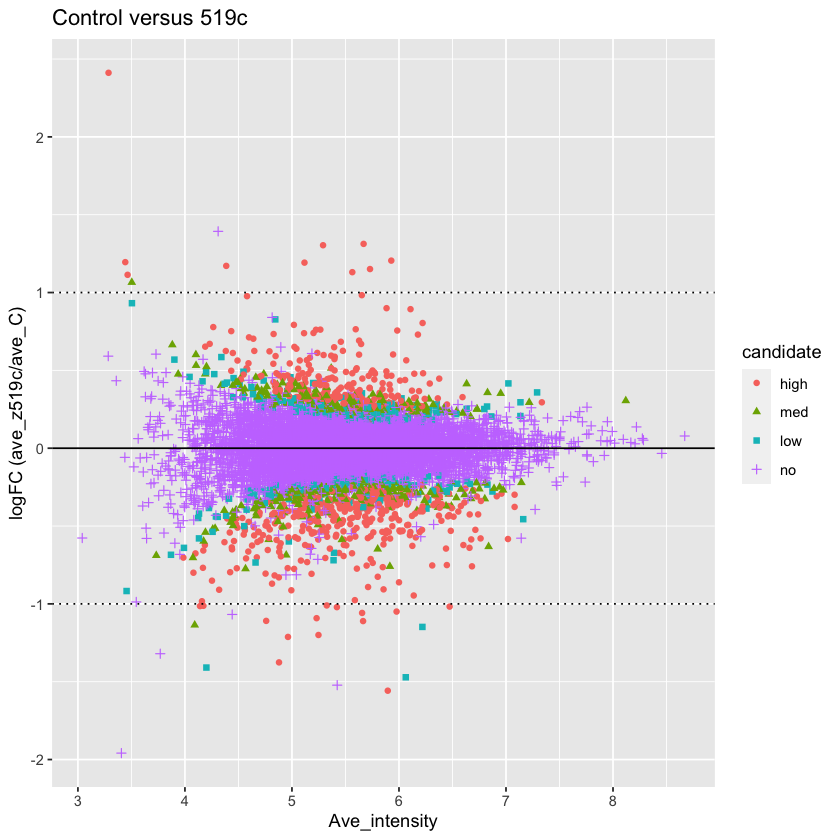

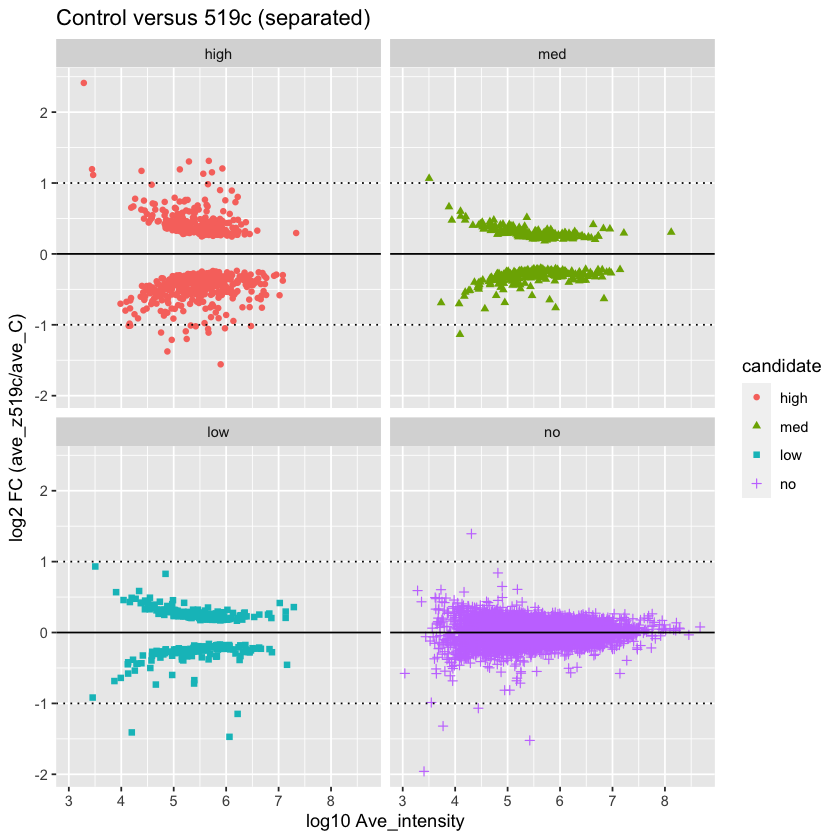

In [55]:
# make MA plots
MA_plots(results, "ave_C", "ave_z519c", "Control versus 519c")

### Scatter plots

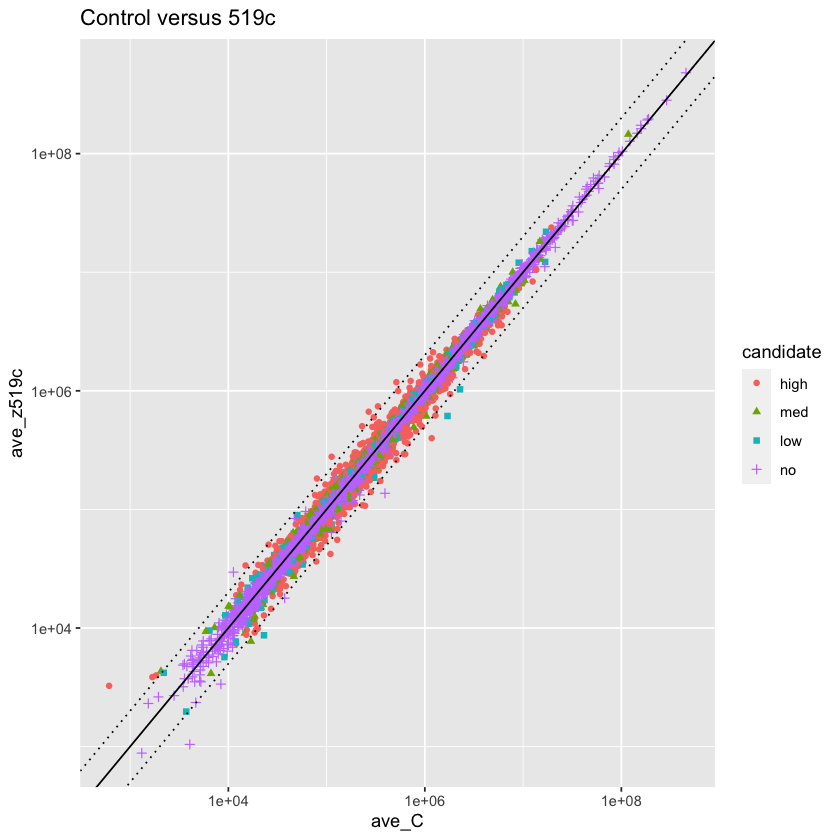

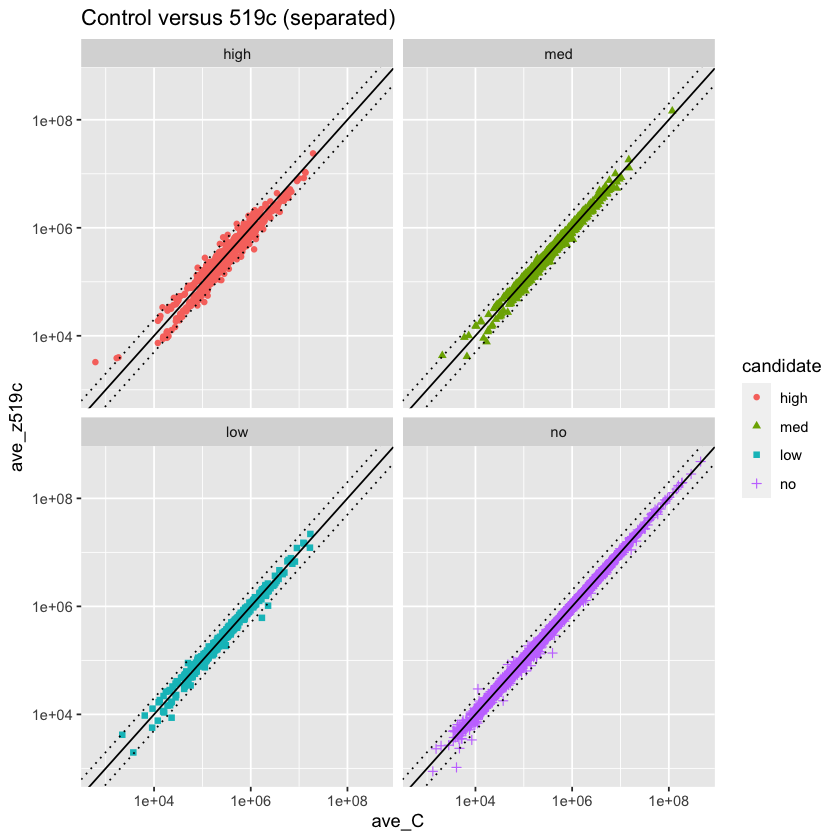

In [56]:
# make scatter plots
scatter_plots(results, "ave_C", "ave_z519c", "Control versus 519c")

### Volcano plot

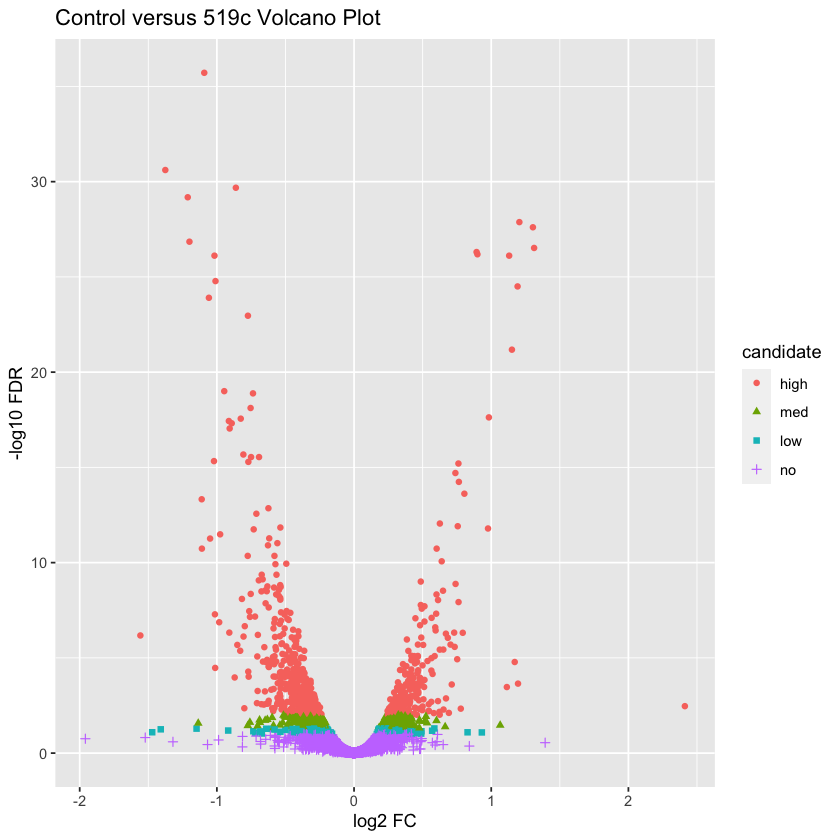

In [57]:
# make a volcano plot
volcano_plot(results, "ave_C", "ave_z519c", "Control versus 519c")

### Expression patterns do not seem much different

We might have some more proteins with slightly larger fold-changes, but it not anything very dramatic. The compressed intensities in MS2 TMT data really alter the statistical testing. Because of the low variance, even modest increases in the differences between means have a strong influence on the testing results.

### Check individual protein expression

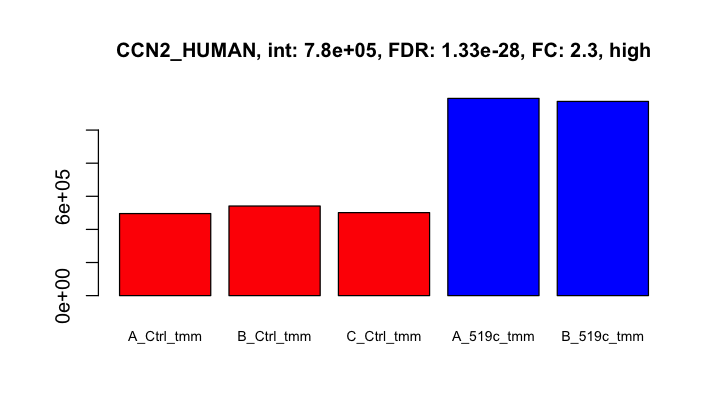

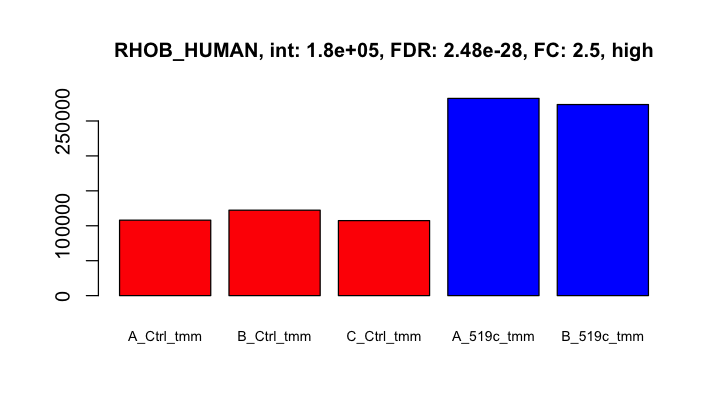

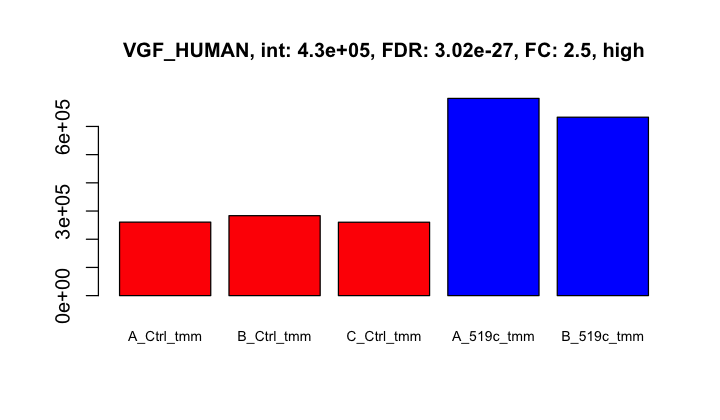

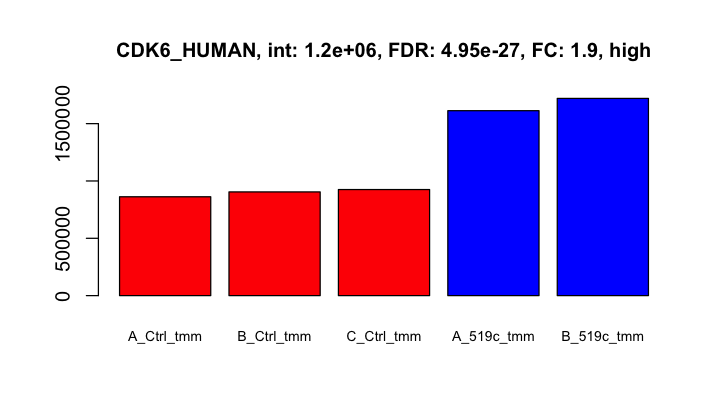

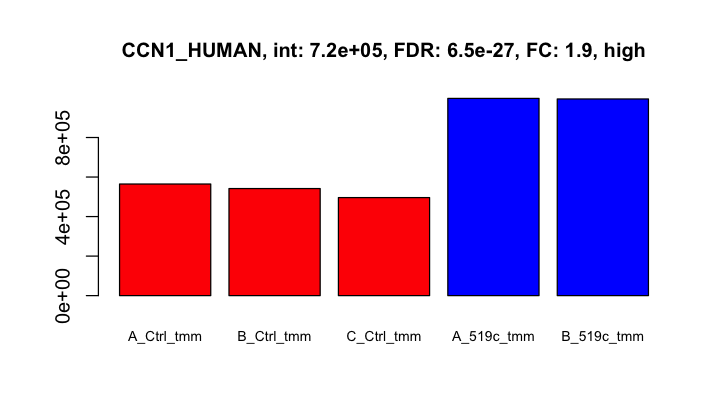

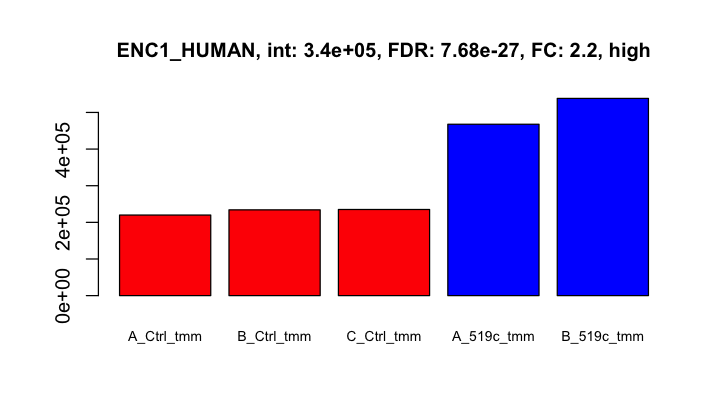

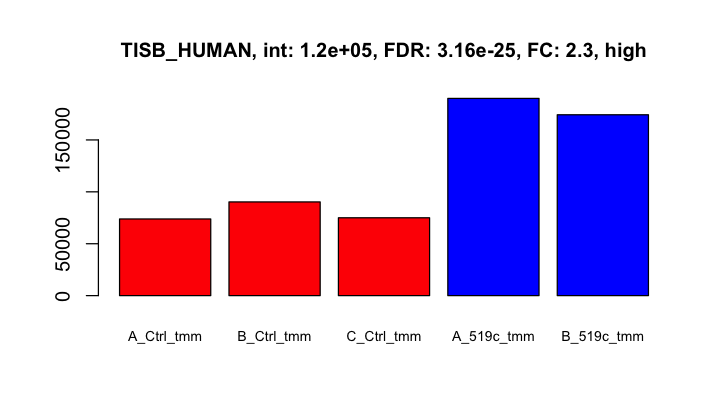

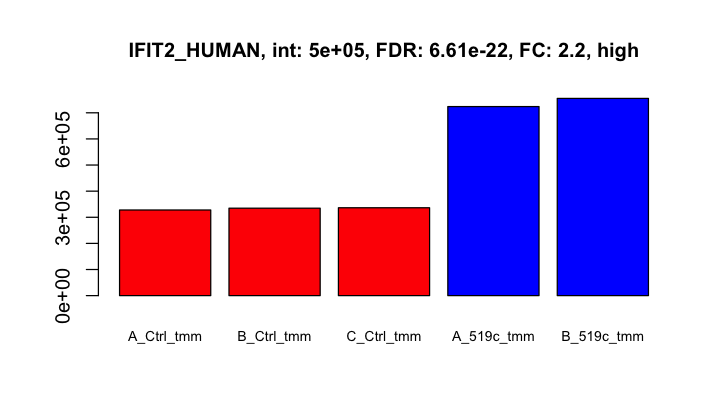

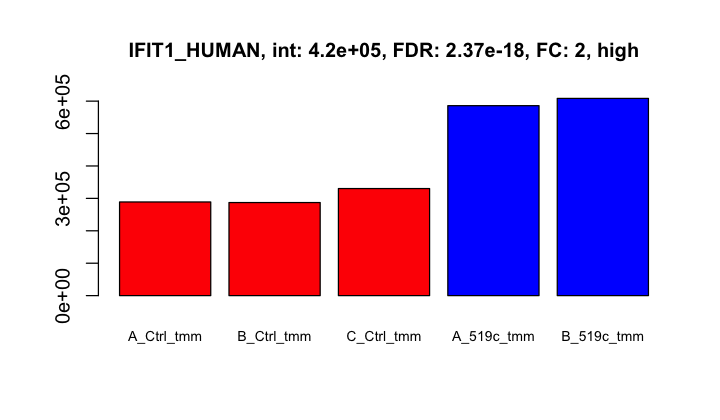

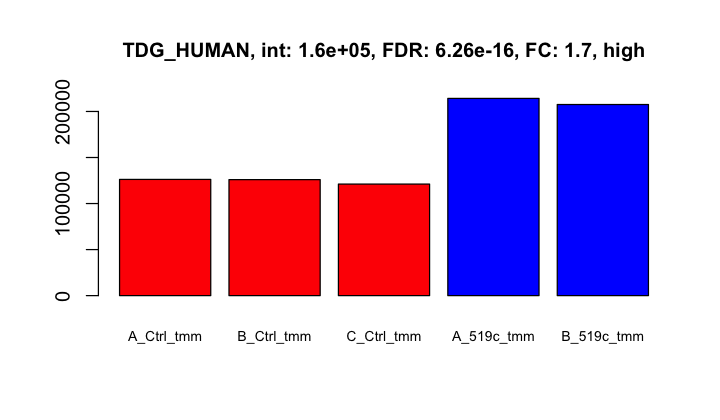

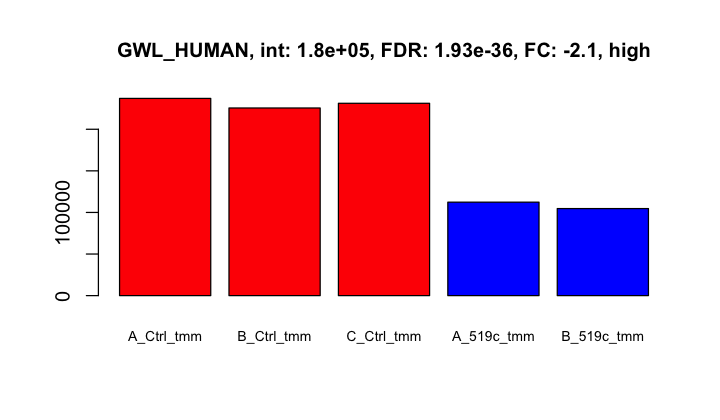

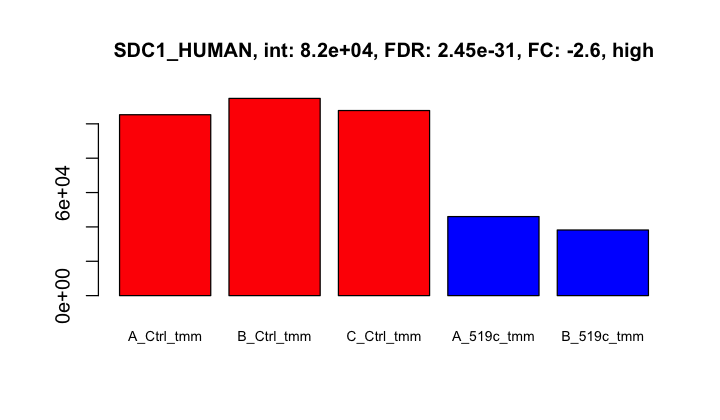

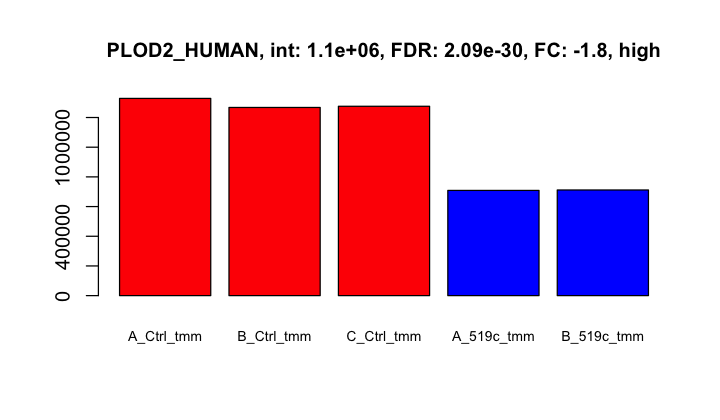

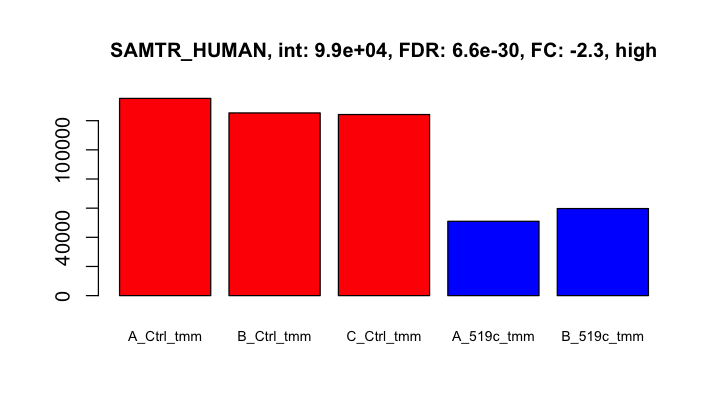

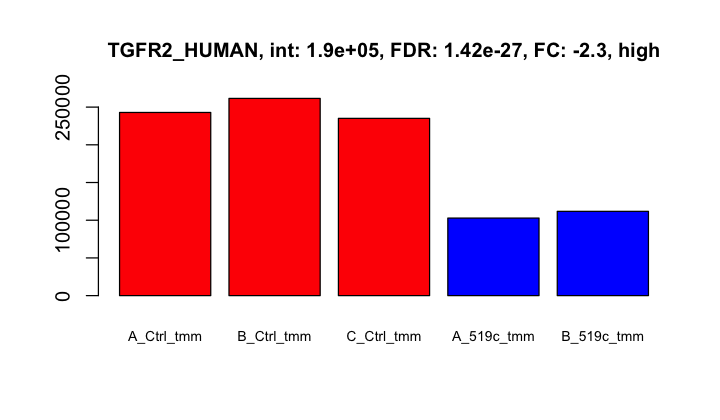

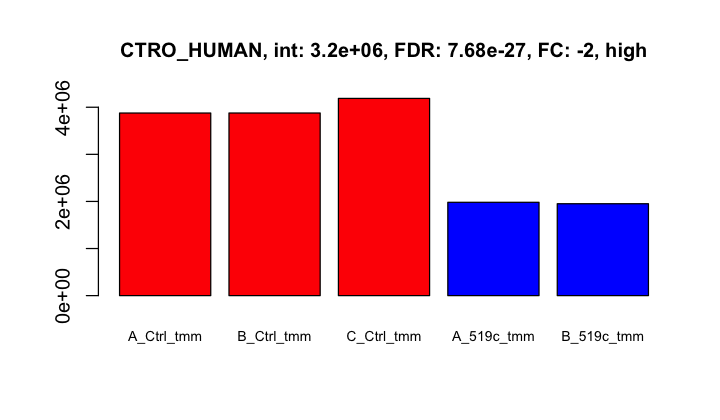

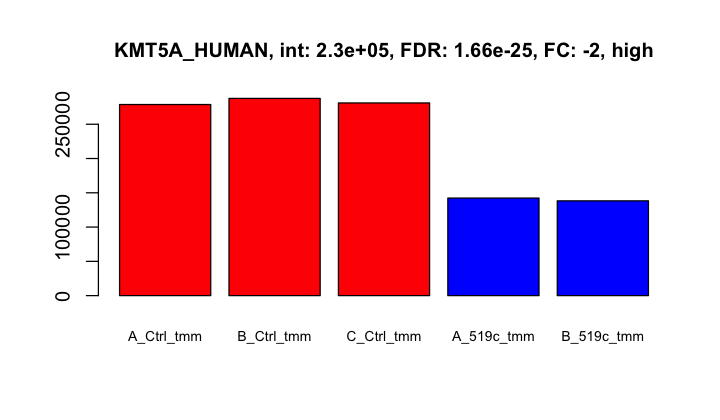

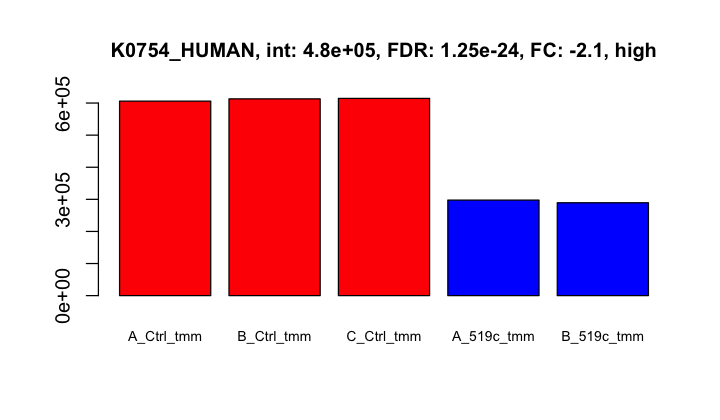

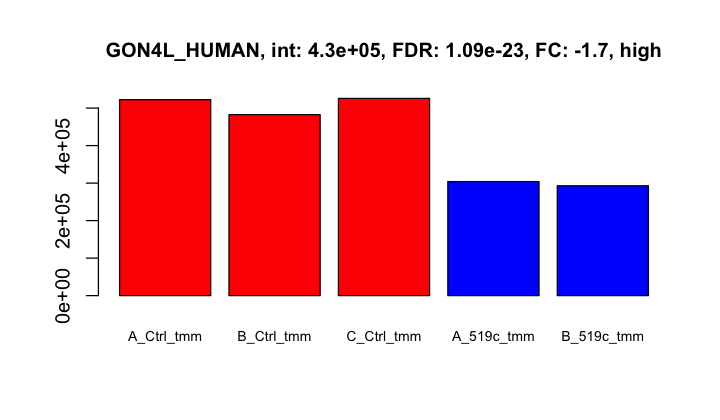

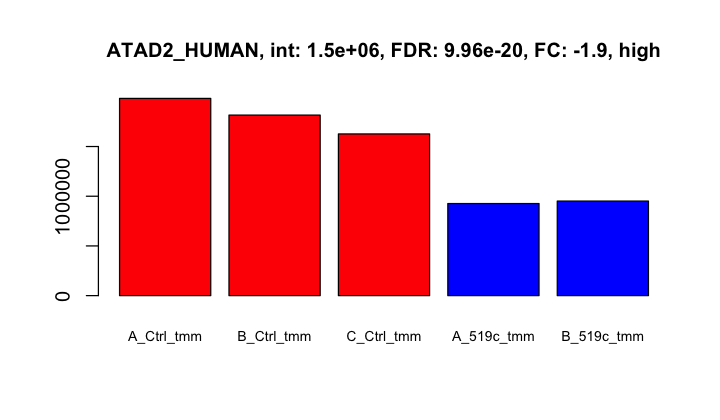

In [58]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 2, 10)
set_plot_dimensions(7, 7)

### We do seem to have a bit larger fold changes for the top candidates

The individual protein expression plots do seem to have larger expression changes for the top tags. We still do not get much more than 2-fold changes for any of the proteins.

---

## <a name="summary"></a> Summary

Notebooks let us provide more context on the analysis that a plain R script can provide. We can easily add quality control visualizations, normalization checks, and multiple types of expression visualizations. We are not really limited, although to many redundant data views may dilute the story telling a little. Keep in mind that the plots you find compelling may be the ones that another reader finds appalling. Censoring a data analysis story for your favorite visualizations is probably a worse choice than having a notebook be a bit longer. Navigations can help.

What about the biology? I don't know. I do not do cancer research. The paper did not present any results from the second or third comparisons (only the controls and the miR-372-3p mimics). That was easy to do here. The IPG range of 3.7 to 4.9 produced more DE candidates than the 3-10 range. Overlap in DE candidates could reduce false positives. Given the way the data seems "squeezed" towards the diagonal, false negative might be more of a concern.

One final note. Reporter ion intensities from MS2 scans do not behave like they should. These bench protocols are complicated and extremely hard to do perfectly. There is going to be sample-to-sample variability. MS2 TMT data is so non-variable it has to be an artifact. I wrote a blog about [TMT ratio distortions](https://pwilmart.github.io/blog/2020/01/05/TMT-ratio-distortions). The more MS2 TMT data I look at, the more convinced I am that the data is **much more** biased than what the newer SPS MS3 methods produce.

---
## Save the `all_results` frame to TSV file

In [59]:
write.table(all_results, "edgeR_IPG3.7-4.9_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [60]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.9.12.31 edgeR_3.24.3    limma_3.38.3    scales_1.1.0   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5     purrr_0.3.3    
 [9] readr_1.3.1     tidyr_1.0.2     tibble_2.1.3    ggplot2_3.3.0  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-40 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.5  reprex_0.3.0    
[13] evaluate